In [5]:
!pip install -q rhino3dm shapely trimesh matplotlib pyvista


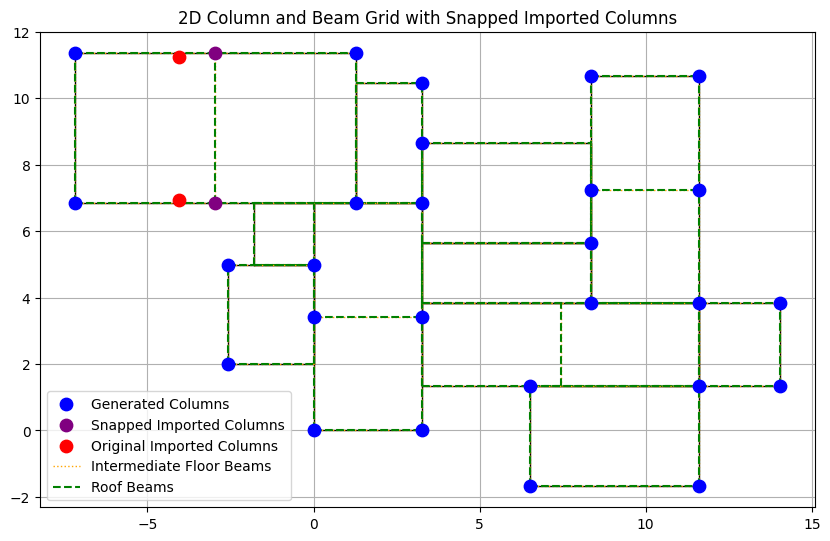

Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x271c4a3b230_0&reconnect=auto" class="pyvis…

In [1]:
# DONT TOUCH

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data):
    pt = np.array([x, y])
    closest_wall = None
    closest_dist = float('inf')

    for wall in wall_data:
        poly = wall['polygon']
        dist = poly.exterior.distance(Point(x, y))
        if dist < closest_dist:
            closest_dist = dist
            closest_wall = wall

    if closest_wall:
        return closest_wall['bbox'].Max.Z
    else:
        return max_z  # fallback


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, wall_breps)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                       radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04  # thinner than column radius 0.1

for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, wall_breps)
    h2 = get_wall_height(x2, y2, wall_breps)
    floor_height = min(h1, h2)

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height (important for cantilevers or partial-height volumes)
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)



# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

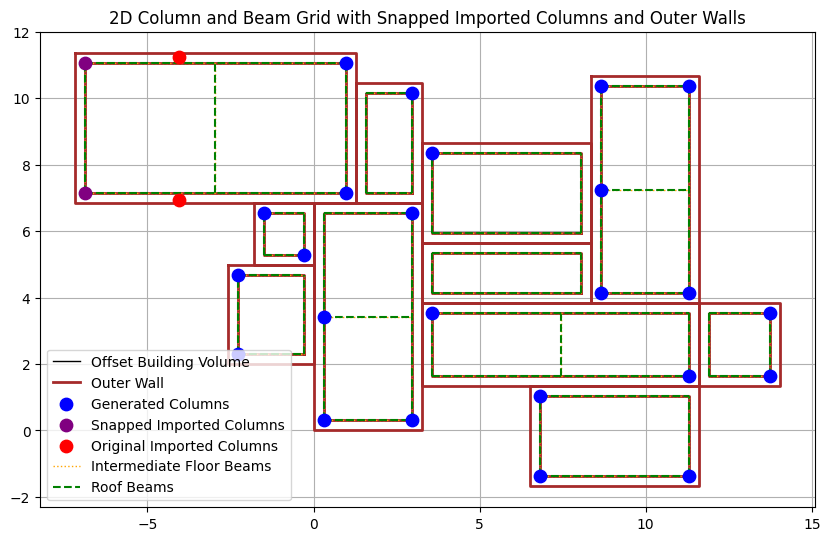

TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

In [2]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

original_wall_breps = [] # Store original bounding box data

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        original_wall_breps.append({'polygon': poly, 'bbox': bbox}) # Store original for wall creation
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for wall thickness
while True:
    try:
        wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3 for 30cm)? "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# Room sorting - Now using the offset polygons for internal logic
offset_building_volumes = []
outer_walls_polygons = []
for original_poly_data in original_wall_breps:
    original_poly = original_poly_data['polygon']
    
    # Create an inner offset for column placement
    offset_poly = original_poly.buffer(-wall_thickness)
    if not offset_poly.is_empty:
        offset_building_volumes.append(offset_poly)
        
        # Create the outer wall polygon (difference between original and offset)
        outer_wall_poly = original_poly.difference(offset_poly)
        if not outer_wall_poly.is_empty:
            outer_walls_polygons.append(outer_wall_poly)


detected_rooms = sorted([(poly, poly.area) for poly in offset_building_volumes], key=lambda x: -x[1])


# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines (offset)
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1, label='Offset Building Volume' if poly == detected_rooms[0][0] else "")

# Outer walls
for wall_poly in outer_walls_polygons:
    px, py = wall_poly.exterior.xy
    ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if wall_poly == outer_walls_polygons[0] else "")
    # If the outer wall is a MultiPolygon (due to complex shapes), iterate its parts
    if wall_poly.geom_type == 'MultiPolygon':
        for single_poly in wall_poly.geoms:
            px, py = single_poly.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2)
            for interior_ring in single_poly.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)
    elif wall_poly.geom_type == 'Polygon':
        for interior_ring in wall_poly.interiors:
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'brown', linewidth=2)


# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns and Outer Walls")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data):
    pt = np.array([x, y])
    closest_wall = None
    closest_dist = float('inf')

    for wall in wall_data:
        poly = wall['polygon']
        dist = poly.exterior.distance(Point(x, y))
        if dist < closest_dist:
            closest_dist = dist
            closest_wall = wall

    if closest_wall:
        return closest_wall['bbox'].Max.Z
    else:
        return max_z  # fallback


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Walls")

# Columns as vertical cylinders
for x, y in all_base_columns:
    wall_height = get_wall_height(x, y, original_wall_breps) # Use original height for columns
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04  # thinner than column radius 0.1

for (x1, y1), (x2, y2) in beams:
    h1 = get_wall_height(x1, y1, original_wall_breps) # Use original height for beams
    h2 = get_wall_height(x2, y2, original_wall_breps)
    floor_height = min(h1, h2)

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height (important for cantilevers or partial-height volumes)
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# Add 3D representation of the outer walls
for wall_poly in outer_walls_polygons:
    # Get the height from the original building volume's bounding box
    wall_bbox = None
    for original_data in original_wall_breps:
        if original_data['polygon'].contains(wall_poly.exterior.coords[0]): # Check if the wall polygon's exterior is within the original
            wall_bbox = original_data['bbox']
            break
    
    if wall_bbox:
        wall_height = wall_bbox.Max.Z
        
        # If the outer wall is a MultiPolygon (due to complex shapes), iterate its parts
        if wall_poly.geom_type == 'MultiPolygon':
            for single_poly in wall_poly.geoms:
                for interior_ring in single_poly.interiors:
                    # Extrude the outer ring and subtract any inner rings
                    outer_coords = list(single_poly.exterior.coords)
                    outer_verts = [(p[0], p[1], 0) for p in outer_coords]
                    
                    inner_coords = list(interior_ring.coords)
                    inner_verts = [(p[0], p[1], 0) for p in inner_coords]

                    # Create a polydata for the outer boundary
                    outer_poly_pv = pv.PolyData(outer_verts).extrude((0, 0, wall_height))
                    plotter.add_mesh(outer_poly_pv, color='brown', opacity=0.7)
        elif wall_poly.geom_type == 'Polygon':
            # Extrude the outer ring and subtract any inner rings
            outer_coords = list(wall_poly.exterior.coords)
            outer_verts = [(p[0], p[1], 0) for p in outer_coords]
            
            # Create a polydata for the outer boundary
            outer_poly_pv = pv.PolyData(outer_verts).extrude((0, 0, wall_height))
            plotter.add_mesh(outer_poly_pv, color='brown', opacity=0.7)
            
            for interior_ring in wall_poly.interiors:
                inner_coords = list(interior_ring.coords)
                inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                # Create a polydata for the inner boundary (hole)
                inner_poly_pv = pv.PolyData(inner_verts).extrude((0, 0, wall_height))
                
                # Subtract the inner hole from the outer wall
                # This part is complex with pyvista for solid subtraction of extruded polygons,
                # so for simple visualization, we'll just add the outer part for now.
                # For accurate solid modeling, dedicated CAD kernels or more advanced libraries would be needed.
                # For this exercise, visual representation of the outer wall is prioritized.


# Actual Brep-based walls visualization (original building outline)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            # Add with very low opacity to show the original building envelope,
            # distinct from the new "outer walls"
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1)

# Set up the camera and show
plotter.show_grid()
plotter.show()

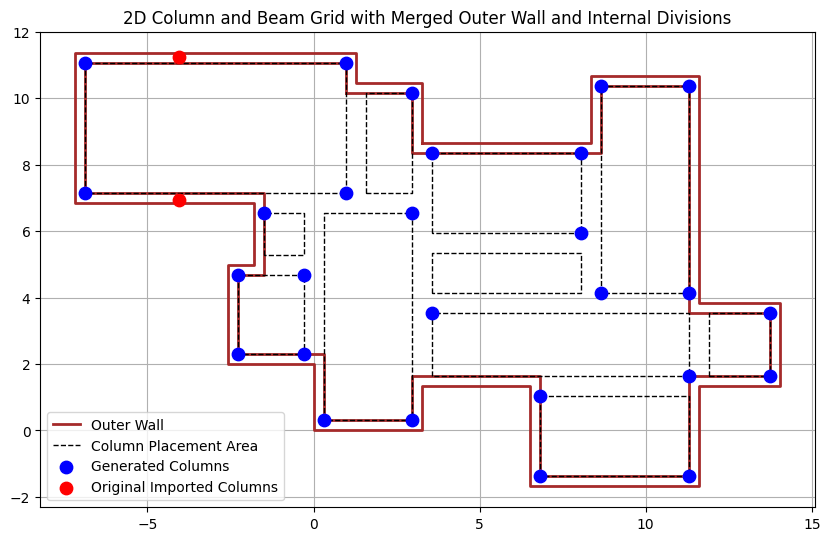

C:\Users\papad\AppData\Roaming\Python\Python313\site-packages\pyvista\core\filters\poly_data.py:3434: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x271d2b9f390_4&reconnect=auto" class="pyvis…

In [5]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from shapely.ops import unary_union # Import for merging polygons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_polygons_2d_original = [] # List to store original 2D shapely Polygons for internal logic
imported_columns = []
max_z = 0.0
building_bbox_data = [] # Stores {'polygon': original_shapely_poly, 'bbox': rhino_bbox}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_polygons_2d_original.append(poly) # Store original polygons
        building_bbox_data.append({'polygon': poly, 'bbox': bbox}) # Keep original data for height lookups
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_polygons_2d_original:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for wall thickness
while True:
    try:
        wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3 for 30cm)? "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# --- Outer Wall Calculation (uses merged perimeter) ---
merged_building_outline = unary_union(building_polygons_2d_original)

temp_offset_outline_for_wall = merged_building_outline.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)

outer_wall_merged_polygon = None
if temp_offset_outline_for_wall and not temp_offset_outline_for_wall.is_empty:
    outer_wall_merged_polygon = merged_building_outline.difference(temp_offset_outline_for_wall)
else:
    # If the inner offset for the wall is empty, the entire merged outline might be the wall
    # This scenario implies the entire footprint becomes "wall" if the offset eats it up.
    # For now, we'll assume a valid inner offset is usually possible for a non-empty building.
    print("Warning: Merged inner offset for outer wall is empty. Outer wall might be missing or cover the whole footprint.")
    # As a fallback, if offset fails, the wall could be the merged outline itself (though likely too thick)
    # outer_wall_merged_polygon = merged_building_outline # Uncomment if this fallback behavior is desired


# --- Column and Beam Placement (uses individual room divisions, offset inwards) ---
detected_rooms = []
for original_poly in building_polygons_2d_original:
    # Offset EACH original room polygon inwards for column placement
    offset_room_poly = original_poly.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)
    if not offset_room_poly.is_empty and offset_room_poly.area > 1e-6: # Ensure it's a valid, non-tiny polygon
        # If offsetting an individual room creates a MultiPolygon (e.g., if it had an internal void)
        if offset_room_poly.geom_type == 'MultiPolygon':
            for single_poly in offset_room_poly.geoms:
                if single_poly.area > 1e-6:
                    detected_rooms.append((single_poly, single_poly.area))
        else: # It's a Polygon
            detected_rooms.append((offset_room_poly, offset_room_poly.area))

detected_rooms.sort(key=lambda x: -x[1]) # Sort by area, largest first


# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy() # This will hold ALL final column locations
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    
    # Generate potential column points on a grid within the room's bounding box
    x_points_grid = np.arange(minx, maxx + MaxS, MaxS)
    y_points_grid = np.arange(miny, maxy + MaxS, MaxS)
    
    # Ensure there's at least one point if the room is smaller than MaxS
    if len(x_points_grid) == 0: x_points_grid = np.array([(minx + maxx) / 2])
    if len(y_points_grid) == 0: y_points_grid = np.array([(miny + maxy) / 2])
    
    room_candidates = []
    for x in x_points_grid:
        for y in y_points_grid:
            p_candidate = Point(x, y)
            # Only consider points strictly inside the current room_poly
            if room_poly.contains(p_candidate):
                room_candidates.append((x, y))

    # Add points close to corners of the room_poly
    for corner_coords in room_poly.exterior.coords:
        p_corner = Point(corner_coords)
        # Ensure corners are within or very close to the boundary of the actual polygon
        if room_poly.contains(p_corner) or room_poly.boundary.distance(p_corner) < 1e-6:
            # Check against ALL existing columns (including those from other rooms or snapped)
            if all(np.linalg.norm(np.array(corner_coords) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(corner_coords)
                existing_columns.append(corner_coords)

    # Now process the filtered room_candidates and try to snap imported columns
    for col_candidate in room_candidates:
        snap = False
        for imp_col in available_imported:
            # Snap imported columns if close enough to a candidate point
            if np.linalg.norm(np.array(col_candidate) - np.array(imp_col)) < MinS:
                corrected_columns.append(col_candidate)
                existing_columns.append(col_candidate)
                available_imported.remove(imp_col) # Mark as used
                snap = True
                break
        # If not snapped, add as a new generated column, ensuring minimum spacing
        if not snap and all(np.linalg.norm(np.array(col_candidate) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col_candidate)
            existing_columns.append(col_candidate)

    # Beam generation logic - only connect columns found within THIS room_poly
    # We need a list of columns that are actually placed within the current room_poly
    current_room_placed_cols = [c for c in existing_columns if room_poly.contains(Point(c)) or room_poly.boundary.distance(Point(c)) < 1e-6]
    
    unique_x = sorted(list(set([c[0] for c in current_room_placed_cols])))
    unique_y = sorted(list(set([c[1] for c in current_room_placed_cols])))
    
    # Generate horizontal beams
    for y_coord in unique_y:
        cols_on_y = sorted([c for c in current_room_placed_cols if abs(c[1] - y_coord) < 1e-6], key=lambda c: c[0])
        for i in range(len(cols_on_y) - 1):
            start_col = cols_on_y[i]
            end_col = cols_on_y[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line):
                 beams.append((start_col, end_col))

    # Generate vertical beams
    for x_coord in unique_x:
        cols_on_x = sorted([c for c in current_room_placed_cols if abs(c[0] - x_coord) < 1e-6], key=lambda c: c[1])
        for i in range(len(cols_on_x) - 1):
            start_col = cols_on_x[i]
            end_col = cols_on_x[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line):
                beams.append((start_col, end_col))


# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the merged outer wall (only if successfully created)
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                px, py = poly.exterior.xy
                ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if poly == outer_wall_merged_polygon.geoms[0] else "")
                for interior_ring in poly.interiors:
                    ix, iy = interior_ring.xy
                    ax.plot(ix, iy, 'brown', linewidth=2)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            px, py = outer_wall_merged_polygon.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall')
            for interior_ring in outer_wall_merged_polygon.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)


# Plot the individual "Column Placement Areas" (offset original rooms)
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k--', linewidth=1, label='Column Placement Area' if poly == detected_rooms[0][0] else "")
    if poly.geom_type == 'Polygon':
        for interior_ring in poly.interiors: # Plot interior rings if they exist (e.g. for donut shapes)
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'k--', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Merged Outer Wall and Internal Divisions")
ax.grid(True)
plt.show()

# Helper to get the correct height for a given 2D point based on original building parts
def get_height_for_point(x, y, building_data_list):
    pt_shapely = Point(x, y)
    for data in building_data_list:
        # Check if point is contained within or very close to the boundary of an original building polygon
        if data['polygon'].contains(pt_shapely) or data['polygon'].exterior.distance(pt_shapely) < 1e-6:
            return data['bbox'].Max.Z
    return max_z # Fallback to max_z if point is outside all known building parts

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Merged Outer Wall")

# Columns as vertical cylinders
for x, y in existing_columns: # Use existing_columns as it contains all placed columns
    wall_height = get_height_for_point(x, y, building_bbox_data) # Use original height
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04

for (x1, y1), (x2, y2) in beams:
    h1 = get_height_for_point(x1, y1, building_bbox_data)
    h2 = get_height_for_point(x2, y2, building_bbox_data)
    floor_height = min(h1, h2) # Beams are constrained by the lowest part of the building they connect

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# Add 3D representation of the merged outer wall
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    wall_height_for_merged = max_z # Default height for the entire merged wall
    
    # Try to find a representative height from building_bbox_data for the wall
    # This is a simplification; for truly varying heights, you might need to tessellate the wall
    # and assign heights based on each segment's location.
    if building_bbox_data:
        # Get height of the largest original building footprint, as a representative
        largest_original_area = 0
        for data in building_bbox_data:
            if data['polygon'].area > largest_original_area:
                largest_original_area = data['polygon'].area
                wall_height_for_merged = data['bbox'].Max.Z
    
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                outer_coords = list(poly.exterior.coords)
                outer_verts = [(p[0], p[1], 0) for p in outer_coords]
                
                if outer_verts:
                    pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

                for interior_ring in poly.interiors:
                    inner_coords = list(interior_ring.coords)
                    inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                    if inner_verts:
                        pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                        plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            outer_coords = list(outer_wall_merged_polygon.exterior.coords)
            outer_verts = [(p[0], p[1], 0) for p in outer_coords]
            if outer_verts:
                pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

            for interior_ring in outer_wall_merged_polygon.interiors:
                inner_coords = list(interior_ring.coords)
                inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                if inner_verts:
                    pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)


# Actual Brep-based walls visualization (original building outline)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1)

# Set up the camera and show
plotter.show_grid()
plotter.show()

In [11]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from shapely.ops import unary_union # Import for merging polygons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
    # If the above path is not correct, let's try the one from the original script.
    rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
    if not os.path.exists(rhino_path):
        raise FileNotFoundError(f"File not found at either of the specified paths.")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_polygons_2d_original = [] # List to store original 2D shapely Polygons for internal logic
imported_columns = []
max_z = 0.0
building_bbox_data = [] # Stores {'polygon': original_shapely_poly, 'bbox': rhino_bbox}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_polygons_2d_original.append(poly) # Store original polygons
        building_bbox_data.append({'polygon': poly, 'bbox': bbox}) # Keep original data for height lookups
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_polygons_2d_original:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for outer wall thickness
while True:
    try:
        outer_wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3)? "))
        if outer_wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# Ask for internal offset for column placement
while True:
    try:
        internal_offset = float(input("How large should the internal offset for column placement be (in meters, e.g., 0.5)? "))
        if internal_offset <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the internal offset.")

# --- Outer Wall Calculation (uses merged perimeter) ---
merged_building_outline = unary_union(building_polygons_2d_original)

temp_offset_outline_for_wall = merged_building_outline.buffer(-outer_wall_thickness, join_style='mitre', mitre_limit=5.0)

outer_wall_merged_polygon = None
if temp_offset_outline_for_wall and not temp_offset_outline_for_wall.is_empty:
    outer_wall_merged_polygon = merged_building_outline.difference(temp_offset_outline_for_wall)
else:
    print("Warning: Merged inner offset for outer wall is empty. Outer wall might be missing or cover the whole footprint.")

# --- Column and Beam Placement (uses individual room divisions, offset inwards) ---
detected_rooms = []
for original_poly in building_polygons_2d_original:
    # Offset EACH original room polygon inwards for column placement using the new internal_offset value
    offset_room_poly = original_poly.buffer(-internal_offset, join_style='mitre', mitre_limit=5.0)
    if not offset_room_poly.is_empty and offset_room_poly.area > 1e-6: # Ensure it's a valid, non-tiny polygon
        if offset_room_poly.geom_type == 'MultiPolygon':
            for single_poly in offset_room_poly.geoms:
                if single_poly.area > 1e-6:
                    detected_rooms.append((single_poly, single_poly.area))
        else: # It's a Polygon
            detected_rooms.append((offset_room_poly, offset_room_poly.area))

detected_rooms.sort(key=lambda x: -x[1]) # Sort by area, largest first


# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy() # This will hold ALL final column locations
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    
    x_points_grid = np.arange(minx, maxx + MaxS, MaxS)
    y_points_grid = np.arange(miny, maxy + MaxS, MaxS)
    
    if len(x_points_grid) == 0: x_points_grid = np.array([(minx + maxx) / 2])
    if len(y_points_grid) == 0: y_points_grid = np.array([(miny + maxy) / 2])
    
    room_candidates = []
    for x in x_points_grid:
        for y in y_points_grid:
            p_candidate = Point(x, y)
            if room_poly.contains(p_candidate):
                room_candidates.append((x, y))

    for corner_coords in room_poly.exterior.coords:
        p_corner = Point(corner_coords)
        if room_poly.contains(p_corner) or room_poly.boundary.distance(p_corner) < 1e-6:
            if all(np.linalg.norm(np.array(corner_coords) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(corner_coords)
                existing_columns.append(corner_coords)

    for col_candidate in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col_candidate) - np.array(imp_col)) < MinS:
                corrected_columns.append(col_candidate)
                existing_columns.append(col_candidate)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col_candidate) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col_candidate)
            existing_columns.append(col_candidate)

    current_room_placed_cols = [c for c in existing_columns if room_poly.contains(Point(c)) or room_poly.boundary.distance(Point(c)) < 1e-6]
    
    unique_x = sorted(list(set([c[0] for c in current_room_placed_cols])))
    unique_y = sorted(list(set([c[1] for c in current_room_placed_cols])))
    
    for y_coord in unique_y:
        cols_on_y = sorted([c for c in current_room_placed_cols if abs(c[1] - y_coord) < 1e-6], key=lambda c: c[0])
        for i in range(len(cols_on_y) - 1):
            start_col = cols_on_y[i]
            end_col = cols_on_y[i+1]
            beam_line = LineString([start_col, end_col])
            if room_poly.contains(beam_line):
                beams.append((start_col, end_col))

    for x_coord in unique_x:
        cols_on_x = sorted([c for c in current_room_placed_cols if abs(c[0] - x_coord) < 1e-6], key=lambda c: c[1])
        for i in range(len(cols_on_x) - 1):
            start_col = cols_on_x[i]
            end_col = cols_on_x[i+1]
            beam_line = LineString([start_col, end_col])
            if room_poly.contains(beam_line):
                beams.append((start_col, end_col))


# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the merged outer wall
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for i, poly in enumerate(outer_wall_merged_polygon.geoms):
            if not poly.is_empty:
                px, py = poly.exterior.xy
                ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if i == 0 else "")
                for interior_ring in poly.interiors:
                    ix, iy = interior_ring.xy
                    ax.plot(ix, iy, 'brown', linewidth=2)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            px, py = outer_wall_merged_polygon.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall')
            for interior_ring in outer_wall_merged_polygon.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)


# Plot the individual "Column Placement Areas"
for i, (poly, _) in enumerate(detected_rooms):
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k--', linewidth=1, label='Column Placement Area' if i == 0 else "")
    if poly.geom_type == 'Polygon':
        for interior_ring in poly.interiors:
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'k--', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

# Beams
for (x1, y1), (x2, y2) in beams:
    ax.plot([x1, x2], [y1, y2], color='black', linestyle='-', linewidth=1, label='Beams' if 'Beams' not in [l.get_label() for l in ax.lines] else "")

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Merged Outer Wall and Internal Divisions")
ax.grid(True)
plt.show()

# Helper to get the correct height
def get_height_for_point(x, y, building_data_list):
    pt_shapely = Point(x, y)
    for data in building_data_list:
        if data['polygon'].contains(pt_shapely) or data['polygon'].exterior.distance(pt_shapely) < 1e-6:
            return data['bbox'].Max.Z
    return max_z

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Merged Outer Wall")

# Columns
for x, y in existing_columns:
    wall_height = get_height_for_point(x, y, building_bbox_data)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)
    plotter.add_mesh(cylinder, color='blue')

# Beams
beam_radius = 0.04
for (x1, y1), (x2, y2) in beams:
    h1 = get_height_for_point(x1, y1, building_bbox_data)
    h2 = get_height_for_point(x2, y2, building_bbox_data)
    floor_height = min(h1, h2)

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor
        if z > h1 or z > h2:
            continue
        start, end = np.array([x1, y1, z]), np.array([x2, y2, z])
        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6: continue
        direction /= length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)
        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# 3D Outer Wall
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    wall_height_for_merged = max_z
    if building_bbox_data:
        largest_original_area = 0
        for data in building_bbox_data:
            if data['polygon'].area > largest_original_area:
                largest_original_area = data['polygon'].area
                wall_height_for_merged = data['bbox'].Max.Z
    
    polygons_to_extrude = []
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        polygons_to_extrude.extend(outer_wall_merged_polygon.geoms)
    else:
        polygons_to_extrude.append(outer_wall_merged_polygon)

    for poly in polygons_to_extrude:
        if not poly.is_empty:
            # This logic correctly handles polygons with holes for extrusion in pyvista
            # by creating a surface with holes and then extruding.
            
            # Exterior outline
            exterior_points = np.array([[p[0], p[1], 0] for p in poly.exterior.coords])
            
            # List of holes
            holes = []
            for interior in poly.interiors:
                holes.append(np.array([[p[0], p[1], 0] for p in interior.coords]))
            
            # Create face and extrude
            face = pv.Face(exterior_points, holes)
            pv_mesh = face.extrude((0, 0, wall_height_for_merged))
            plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)


# Original building Breps (for context)
def mesh_brep(brep):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(rhino3dm.MeshType.Any)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    if obj.Attributes.LayerIndex == layers['building'] and isinstance(geom, rhino3dm.Brep):
        for mesh in mesh_brep(geom):
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = [item for f in mesh.Faces for item in ((4 if len(f) == 4 else 3,) + f)]
            pv_mesh = pv.PolyData(pts, faces)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1, style='wireframe')

plotter.show_grid()
plotter.show()

IndentationError: unexpected indent (3797167467.py, line 13)

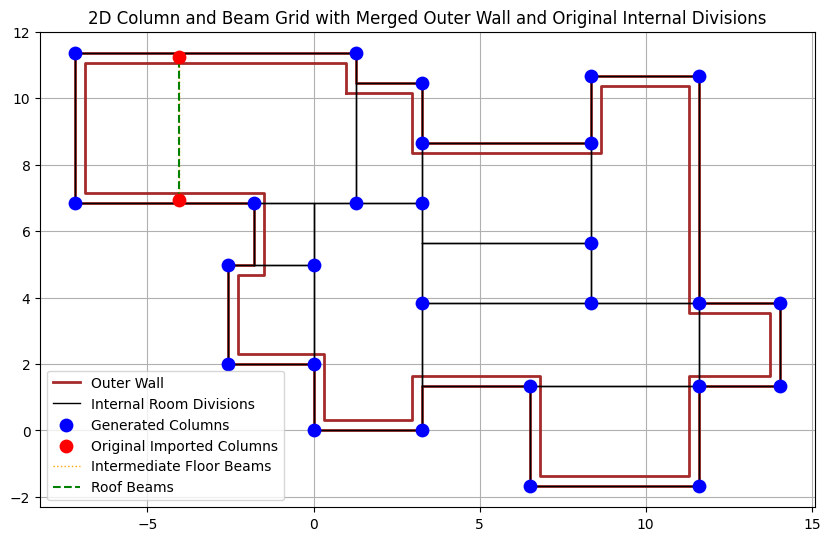

C:\Users\papad\AppData\Roaming\Python\Python313\site-packages\pyvista\core\filters\poly_data.py:3434: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x271f6270410_6&reconnect=auto" class="pyvis…

In [7]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from shapely.ops import unary_union # Import for merging polygons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# User-provided saved information: rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
# Using the path from the conversation history, which is also in the provided code:
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_polygons_2d_original = [] # List to store original 2D shapely Polygons for internal logic
imported_columns = []
max_z = 0.0
building_bbox_data = [] # Stores {'polygon': original_shapely_poly, 'bbox': rhino_bbox}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_polygons_2d_original.append(poly) # Store original polygons
        building_bbox_data.append({'polygon': poly, 'bbox': bbox}) # Keep original data for height lookups
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_polygons_2d_original:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for wall thickness
while True:
    try:
        wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3 for 30cm)? "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# --- Outer Wall Calculation (uses merged perimeter) ---
merged_building_outline = unary_union(building_polygons_2d_original)

# Apply negative buffer to the MERGED outline for the inner boundary of the thick wall
temp_offset_outline_for_wall = merged_building_outline.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)

outer_wall_merged_polygon = None
if temp_offset_outline_for_wall and not temp_offset_outline_for_wall.is_empty:
    outer_wall_merged_polygon = merged_building_outline.difference(temp_offset_outline_for_wall)
else:
    print("Warning: Merged inner offset for outer wall is empty. Outer wall might be missing or cover the whole footprint.")


# --- Column and Beam Placement (uses ORIGINAL individual room divisions, NO OFFSET) ---
# The 'detected_rooms' are simply the original individual building polygons.
# Columns and beams will be placed within these exact boundaries.
detected_rooms = sorted([(poly, poly.area) for poly in building_polygons_2d_original], key=lambda x: -x[1])


# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy() # This will hold ALL final column locations
beams = []

for room_poly, _ in detected_rooms: # room_poly is now the ORIGINAL polygon
    minx, miny, maxx, maxy = room_poly.bounds
    
    # Generate potential column points on a grid within the room's bounding box
    x_points_grid = np.arange(minx, maxx + MaxS, MaxS)
    y_points_grid = np.arange(miny, maxy + MaxS, MaxS)
    
    # Ensure there's at least one point if the room is smaller than MaxS
    if len(x_points_grid) == 0: x_points_grid = np.array([(minx + maxx) / 2])
    if len(y_points_grid) == 0: y_points_grid = np.array([(miny + maxy) / 2])
    
    room_candidates = []
    for x in x_points_grid:
        for y in y_points_grid:
            p_candidate = Point(x, y)
            # Only consider points strictly inside the current room_poly (original boundaries)
            if room_poly.contains(p_candidate):
                room_candidates.append((x, y))

    # Add points close to corners of the room_poly
    for corner_coords in room_poly.exterior.coords:
        p_corner = Point(corner_coords)
        # Ensure corners are within or very close to the boundary of the actual polygon
        if room_poly.contains(p_corner) or room_poly.boundary.distance(p_corner) < 1e-6:
            # Check against ALL existing columns (including those from other rooms or snapped)
            if all(np.linalg.norm(np.array(corner_coords) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(corner_coords)
                existing_columns.append(corner_coords)

    # Now process the filtered room_candidates and try to snap imported columns
    for col_candidate in room_candidates:
        snap = False
        for imp_col in available_imported:
            # Snap imported columns if close enough to a candidate point
            if np.linalg.norm(np.array(col_candidate) - np.array(imp_col)) < MinS:
                corrected_columns.append(col_candidate)
                existing_columns.append(col_candidate)
                available_imported.remove(imp_col) # Mark as used
                snap = True
                break
        # If not snapped, add as a new generated column, ensuring minimum spacing
        if not snap and all(np.linalg.norm(np.array(col_candidate) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col_candidate)
            existing_columns.append(col_candidate)

    # Beam generation logic - only connect columns found within THIS room_poly
    current_room_placed_cols = [c for c in existing_columns if room_poly.contains(Point(c)) or room_poly.boundary.distance(Point(c)) < 1e-6]
    
    unique_x = sorted(list(set([c[0] for c in current_room_placed_cols])))
    unique_y = sorted(list(set([c[1] for c in current_room_placed_cols])))
    
    # Generate horizontal beams
    for y_coord in unique_y:
        cols_on_y = sorted([c for c in current_room_placed_cols if abs(c[1] - y_coord) < 1e-6], key=lambda c: c[0])
        for i in range(len(cols_on_y) - 1):
            start_col = cols_on_y[i]
            end_col = cols_on_y[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line): # This check now uses the ORIGINAL room_poly
                 beams.append((start_col, end_col))

    # Generate vertical beams
    for x_coord in unique_x:
        cols_on_x = sorted([c for c in current_room_placed_cols if abs(c[0] - x_coord) < 1e-6], key=lambda c: c[1])
        for i in range(len(cols_on_x) - 1):
            start_col = cols_on_x[i]
            end_col = cols_on_x[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line): # This check now uses the ORIGINAL room_poly
                beams.append((start_col, end_col))


# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the merged outer wall (only if successfully created)
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                px, py = poly.exterior.xy
                ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if poly == outer_wall_merged_polygon.geoms[0] else "")
                for interior_ring in poly.interiors:
                    ix, iy = interior_ring.xy
                    ax.plot(ix, iy, 'brown', linewidth=2)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            px, py = outer_wall_merged_polygon.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall')
            for interior_ring in outer_wall_merged_polygon.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)


# Plot the individual "Internal Room Divisions" as thin black lines (ORIGINAL SHAPES)
for poly, _ in detected_rooms: # detected_rooms now directly hold original polygons
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1, label='Internal Room Divisions' if poly == detected_rooms[0][0] else "")
    if poly.geom_type == 'Polygon':
        for interior_ring in poly.interiors:
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'k-', linewidth=1)


# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
# Update legend to reflect new label for internal divisions
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())

plt.title("2D Column and Beam Grid with Merged Outer Wall and Original Internal Divisions")
ax.grid(True)
plt.show()

# Helper to get the correct height for a given 2D point based on original building parts
def get_height_for_point(x, y, building_data_list):
    pt_shapely = Point(x, y)
    for data in building_data_list:
        # Check if point is contained within or very close to the boundary of an original building polygon
        if data['polygon'].contains(pt_shapely) or data['polygon'].exterior.distance(pt_shapely) < 1e-6:
            return data['bbox'].Max.Z
    return max_z # Fallback to max_z if point is outside all known building parts

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Merged Outer Wall")

# Columns as vertical cylinders
for x, y in existing_columns: # Use existing_columns as it contains all placed columns
    wall_height = get_height_for_point(x, y, building_bbox_data) # Use original height
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04

for (x1, y1), (x2, y2) in beams:
    h1 = get_height_for_point(x1, y1, building_bbox_data)
    h2 = get_height_for_point(x2, y2, building_bbox_data)
    floor_height = min(h1, h2) # Beams are constrained by the lowest part of the building they connect

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# Add 3D representation of the merged outer wall
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    wall_height_for_merged = max_z # Default height for the entire merged wall
    
    # Try to find a representative height from building_bbox_data for the wall
    if building_bbox_data:
        largest_original_area = 0
        for data in building_bbox_data:
            if data['polygon'].area > largest_original_area:
                largest_original_area = data['polygon'].area
                wall_height_for_merged = data['bbox'].Max.Z
    
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                outer_coords = list(poly.exterior.coords)
                outer_verts = [(p[0], p[1], 0) for p in outer_coords]
                
                if outer_verts:
                    pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

                for interior_ring in poly.interiors:
                    inner_coords = list(interior_ring.coords)
                    inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                    if inner_verts:
                        pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                        plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            outer_coords = list(outer_wall_merged_polygon.exterior.coords)
            outer_verts = [(p[0], p[1], 0) for p in outer_coords]
            if outer_verts:
                pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

            for interior_ring in outer_wall_merged_polygon.interiors:
                inner_coords = list(interior_ring.coords)
                inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                if inner_verts:
                    pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)


# Actual Brep-based walls visualization (original building outline)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1)

# Set up the camera and show
plotter.show_grid()
plotter.show()

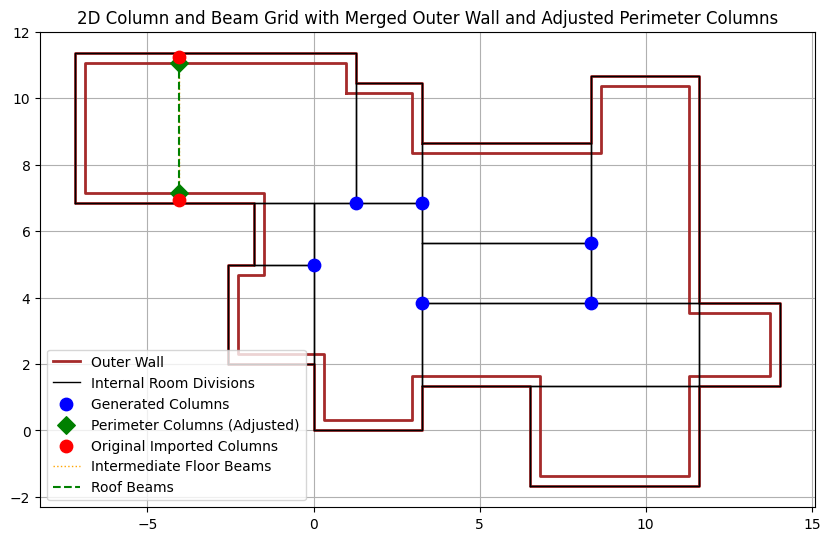

C:\Users\papad\AppData\Roaming\Python\Python313\site-packages\pyvista\core\filters\poly_data.py:3434: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x271da6660d0_7&reconnect=auto" class="pyvis…

In [8]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from shapely.ops import unary_union # Import for merging polygons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_polygons_2d_original = [] # List to store original 2D shapely Polygons for internal logic
imported_columns = []
max_z = 0.0
building_bbox_data = [] # Stores {'polygon': original_shapely_poly, 'bbox': rhino_bbox}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_polygons_2d_original.append(poly) # Store original polygons
        building_bbox_data.append({'polygon': poly, 'bbox': bbox}) # Keep original data for height lookups
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_polygons_2d_original:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for wall thickness
while True:
    try:
        wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3 for 30cm)? "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# --- Outer Wall Calculation ---
merged_building_outline = unary_union(building_polygons_2d_original)

# This is the INNER boundary of the overall building footprint after wall thickness is applied
inner_merged_offset_area = merged_building_outline.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)

outer_wall_merged_polygon = None
if inner_merged_offset_area and not inner_merged_offset_area.is_empty:
    outer_wall_merged_polygon = merged_building_outline.difference(inner_merged_offset_area)
else:
    print("Warning: Merged inner offset for outer wall is empty. Outer wall might be missing or cover the whole footprint.")

# --- Column and Beam Placement (uses ORIGINAL individual room divisions) ---
detected_rooms = sorted([(poly, poly.area) for poly in building_polygons_2d_original], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0
COLUMN_SNAP_THRESHOLD = wall_thickness * 1.5 # A bit more than wall thickness to consider it a perimeter column

columns = [] # Newly generated internal columns
corrected_columns = [] # Snapped imported internal columns
perimeter_columns = [] # Specifically for columns snapped to the perimeter
available_imported = imported_columns.copy()
existing_columns = [] # This will hold ALL final column locations (internal, perimeter, snapped)
beams = []

# First, process imported columns and determine if they are perimeter or internal
# We do this before generating new columns to ensure proper snapping and placement priority
for imp_col_coords in imported_columns:
    imp_col_point = Point(imp_col_coords)
    
    # Check if the imported column is near the merged outer perimeter
    # Distance to the exterior of the *original* merged outline
    dist_to_merged_exterior = merged_building_outline.exterior.distance(imp_col_point)

    is_perimeter_candidate = False
    if dist_to_merged_exterior < COLUMN_SNAP_THRESHOLD: # If it's close to the building edge
        # Check if the point is *outside* the inner_merged_offset_area or very close to its boundary
        if not inner_merged_offset_area or \
           (not inner_merged_offset_area.contains(imp_col_point) and \
            inner_merged_offset_area.exterior.distance(imp_col_point) < COLUMN_SNAP_THRESHOLD):
            is_perimeter_candidate = True

    if is_perimeter_candidate:
        # For perimeter columns, try to place them just inside the inner_merged_offset_area
        # Find the closest point on the *inner* boundary of the overall building outline
        if inner_merged_offset_area and not inner_merged_offset_area.is_empty:
            closest_point_on_inner_boundary = inner_merged_offset_area.exterior.interpolate(
                inner_merged_offset_area.exterior.project(imp_col_point)
            )
            # Try to snap to a grid within the general area or adjust slightly
            # For simplicity, we'll place it directly at a "snapped" location inside
            # A more advanced approach might involve projecting onto the inner boundary.
            # For now, let's just make sure it's within the inner_merged_offset_area.
            if inner_merged_offset_area.contains(imp_col_point) or inner_merged_offset_area.exterior.distance(imp_col_point) < wall_thickness * 0.5:
                # If it's already inside or very close to inner boundary, keep it
                perimeter_columns.append(imp_col_coords)
            else:
                # If it's outside but a perimeter candidate, move it to the closest point on the inner_merged_offset_area.exterior
                # This is a crude snap, a grid-based snap would be better.
                adjusted_point = (closest_point_on_inner_boundary.x, closest_point_on_inner_boundary.y)
                perimeter_columns.append(adjusted_point)
            existing_columns.append(imp_col_coords) # Add original for tracking, but perimeter_columns holds the refined one
        else: # Fallback if inner_merged_offset_area is empty
            existing_columns.append(imp_col_coords)
            perimeter_columns.append(imp_col_coords)
    else:
        # If not a perimeter candidate, it's an internal imported column
        corrected_columns.append(imp_col_coords)
        existing_columns.append(imp_col_coords)

# Now, generate new internal columns based on individual room divisions
for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    
    x_points_grid = np.arange(minx, maxx + MaxS, MaxS)
    y_points_grid = np.arange(miny, maxy + MaxS, MaxS)
    
    if len(x_points_grid) == 0: x_points_grid = np.array([(minx + maxx) / 2])
    if len(y_points_grid) == 0: y_points_grid = np.array([(miny + maxy) / 2])
    
    room_candidates = []
    for x in x_points_grid:
        for y in y_points_grid:
            p_candidate = Point(x, y)
            if room_poly.contains(p_candidate):
                room_candidates.append((x, y))

    for col_candidate in room_candidates:
        # Check against all existing columns (including already processed imported ones)
        if all(np.linalg.norm(np.array(col_candidate) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            # Also, ensure generated columns are not too close to the outer merged perimeter.
            # We already handled imported perimeter columns. For new generated ones, they should be internal.
            p_candidate_point = Point(col_candidate)
            # If the candidate is within the inner offset area (meaning it's inside the wall)
            if inner_merged_offset_area and inner_merged_offset_area.contains(p_candidate_point):
                columns.append(col_candidate)
                existing_columns.append(col_candidate)
            elif not inner_merged_offset_area: # Fallback if no inner area (e.g., very small building)
                 columns.append(col_candidate)
                 existing_columns.append(col_candidate)

    # Add points close to corners of the original room_poly, but also ensure they are internal to the overall structure
    for corner_coords in room_poly.exterior.coords:
        p_corner = Point(corner_coords)
        if (room_poly.contains(p_corner) or room_poly.boundary.distance(p_corner) < 1e-6) and \
           (inner_merged_offset_area and inner_merged_offset_area.contains(p_corner)):
            if all(np.linalg.norm(np.array(corner_coords) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(corner_coords)
                existing_columns.append(corner_coords)

# Beams logic remains the same, connecting existing_columns within their respective room_polys
beams = []
# Re-iterate through detected_rooms to generate beams for each specific room
for room_poly, _ in detected_rooms:
    current_room_placed_cols = [c for c in existing_columns if room_poly.contains(Point(c)) or room_poly.boundary.distance(Point(c)) < 1e-6]
    
    unique_x = sorted(list(set([c[0] for c in current_room_placed_cols])))
    unique_y = sorted(list(set([c[1] for c in current_room_placed_cols])))
    
    # Generate horizontal beams
    for y_coord in unique_y:
        cols_on_y = sorted([c for c in current_room_placed_cols if abs(c[1] - y_coord) < 1e-6], key=lambda c: c[0])
        for i in range(len(cols_on_y) - 1):
            start_col = cols_on_y[i]
            end_col = cols_on_y[i+1]
            beam_line = LineString([start_col, end_col])
            if room_poly.contains(beam_line):
                 beams.append((start_col, end_col))

    # Generate vertical beams
    for x_coord in unique_x:
        cols_on_x = sorted([c for c in current_room_placed_cols if abs(c[0] - x_coord) < 1e-6], key=lambda c: c[1])
        for i in range(len(cols_on_x) - 1):
            start_col = cols_on_x[i]
            end_col = cols_on_x[i+1]
            beam_line = LineString([start_col, end_col])
            if room_poly.contains(beam_line):
                beams.append((start_col, end_col))


# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the merged outer wall (only if successfully created)
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                px, py = poly.exterior.xy
                ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if poly == outer_wall_merged_polygon.geoms[0] else "")
                for interior_ring in poly.interiors:
                    ix, iy = interior_ring.xy
                    ax.plot(ix, iy, 'brown', linewidth=2)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            px, py = outer_wall_merged_polygon.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall')
            for interior_ring in outer_wall_merged_polygon.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)


# Plot the individual "Internal Room Divisions" as thin black lines (ORIGINAL SHAPES)
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1, label='Internal Room Divisions' if poly == detected_rooms[0][0] else "")
    if poly.geom_type == 'Polygon':
        for interior_ring in poly.interiors:
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'k-', linewidth=1)


# Generated columns (internal)
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns (internal)
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns (Internal)', zorder=7)

# Perimeter columns (can be generated or snapped)
if perimeter_columns:
    px, py = zip(*perimeter_columns)
    ax.scatter(px, py, c='green', s=80, marker='D', label='Perimeter Columns (Adjusted)', zorder=6) # Use a different marker/color

# Original imported columns (for reference, will likely be covered by snapped/adjusted)
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())

plt.title("2D Column and Beam Grid with Merged Outer Wall and Adjusted Perimeter Columns")
ax.grid(True)
plt.show()

# Helper to get the correct height for a given 2D point based on original building parts
def get_height_for_point(x, y, building_data_list):
    pt_shapely = Point(x, y)
    for data in building_data_list:
        if data['polygon'].contains(pt_shapely) or data['polygon'].exterior.distance(pt_shapely) < 1e-6:
            return data['bbox'].Max.Z
    return max_z

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Merged Outer Wall")

# Columns as vertical cylinders - now using the combined list
# We need to make sure 'existing_columns' only contains the *final* positions
# Let's rebuild existing_columns from 'columns', 'corrected_columns', and 'perimeter_columns'
final_columns_for_3d = []
final_columns_for_3d.extend(columns)
final_columns_for_3d.extend(corrected_columns)
final_columns_for_3d.extend(perimeter_columns)
# Remove duplicates in case any column ended up in multiple lists (unlikely with logic but good practice)
final_columns_for_3d = list(set(final_columns_for_3d))


for x, y in final_columns_for_3d:
    wall_height = get_height_for_point(x, y, building_bbox_data)
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)
    # Assign color based on its type if possible for visual debugging in 3D
    color = 'blue' # Default for generated
    if (x,y) in perimeter_columns:
        color = 'green' # Adjusted perimeter
    elif (x,y) in corrected_columns:
        color = 'purple' # Snapped internal
    plotter.add_mesh(cylinder, color=color)

# Beams as thinner cylinders
beam_radius = 0.04

for (x1, y1), (x2, y2) in beams:
    h1 = get_height_for_point(x1, y1, building_bbox_data)
    h2 = get_height_for_point(x2, y2, building_bbox_data)
    floor_height = min(h1, h2)

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# Add 3D representation of the merged outer wall
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    wall_height_for_merged = max_z
    
    if building_bbox_data:
        largest_original_area = 0
        for data in building_bbox_data:
            if data['polygon'].area > largest_original_area:
                largest_original_area = data['polygon'].area
                wall_height_for_merged = data['bbox'].Max.Z
    
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                outer_coords = list(poly.exterior.coords)
                outer_verts = [(p[0], p[1], 0) for p in outer_coords]
                
                if outer_verts:
                    pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

                for interior_ring in poly.interiors:
                    inner_coords = list(interior_ring.coords)
                    inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                    if inner_verts:
                        pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                        plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            outer_coords = list(outer_wall_merged_polygon.exterior.coords)
            outer_verts = [(p[0], p[1], 0) for p in outer_coords]
            if outer_verts:
                pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

            for interior_ring in outer_wall_merged_polygon.interiors:
                inner_coords = list(interior_ring.coords)
                inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                if inner_verts:
                    pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)


# Actual Brep-based walls visualization (original building outline)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1)

# Set up the camera and show
plotter.show_grid()
plotter.show()

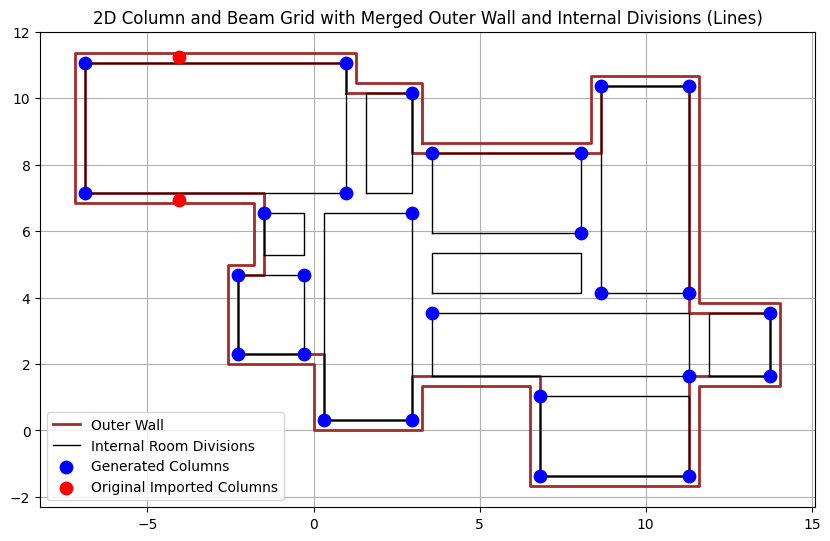

C:\Users\papad\AppData\Roaming\Python\Python313\site-packages\pyvista\core\filters\poly_data.py:3434: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


Widget(value='<iframe src="http://localhost:55784/index.html?ui=P_0x271d99cf390_5&reconnect=auto" class="pyvis…

In [6]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
from shapely.ops import unary_union # Import for merging polygons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# User-provided saved information: rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
# Using the path from the conversation history, which is also in the provided code:
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_polygons_2d_original = [] # List to store original 2D shapely Polygons for internal logic
imported_columns = []
max_z = 0.0
building_bbox_data = [] # Stores {'polygon': original_shapely_poly, 'bbox': rhino_bbox}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        poly = Polygon(base_pts)
        building_polygons_2d_original.append(poly) # Store original polygons
        building_bbox_data.append({'polygon': poly, 'bbox': bbox}) # Keep original data for height lookups
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_polygons_2d_original:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Ask for wall thickness
while True:
    try:
        wall_thickness = float(input("How thick do you want the outer wall to be (in meters, e.g., 0.3 for 30cm)? "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for the wall thickness.")

# --- Outer Wall Calculation (uses merged perimeter) ---
merged_building_outline = unary_union(building_polygons_2d_original)

temp_offset_outline_for_wall = merged_building_outline.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)

outer_wall_merged_polygon = None
if temp_offset_outline_for_wall and not temp_offset_outline_for_wall.is_empty:
    outer_wall_merged_polygon = merged_building_outline.difference(temp_offset_outline_for_wall)
else:
    print("Warning: Merged inner offset for outer wall is empty. Outer wall might be missing or cover the whole footprint.")


# --- Column and Beam Placement (uses individual room divisions, offset inwards) ---
# This list will store the *offset polygons* that define the areas where columns/beams are placed.
# These polygons themselves are not "walls", but define the space for the structure.
detected_rooms = []
for original_poly in building_polygons_2d_original:
    # Offset EACH original room polygon inwards for column placement
    offset_room_poly = original_poly.buffer(-wall_thickness, join_style='mitre', mitre_limit=5.0)
    if not offset_room_poly.is_empty and offset_room_poly.area > 1e-6: # Ensure it's a valid, non-tiny polygon
        # If offsetting an individual room creates a MultiPolygon (e.g., if it had an internal void)
        if offset_room_poly.geom_type == 'MultiPolygon':
            for single_poly in offset_room_poly.geoms:
                if single_poly.area > 1e-6:
                    detected_rooms.append((single_poly, single_poly.area))
        else: # It's a Polygon
            detected_rooms.append((offset_room_poly, offset_room_poly.area))

detected_rooms.sort(key=lambda x: -x[1]) # Sort by area, largest first


# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy() # This will hold ALL final column locations
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    
    # Generate potential column points on a grid within the room's bounding box
    x_points_grid = np.arange(minx, maxx + MaxS, MaxS)
    y_points_grid = np.arange(miny, maxy + MaxS, MaxS)
    
    # Ensure there's at least one point if the room is smaller than MaxS
    if len(x_points_grid) == 0: x_points_grid = np.array([(minx + maxx) / 2])
    if len(y_points_grid) == 0: y_points_grid = np.array([(miny + maxy) / 2])
    
    room_candidates = []
    for x in x_points_grid:
        for y in y_points_grid:
            p_candidate = Point(x, y)
            # Only consider points strictly inside the current room_poly
            if room_poly.contains(p_candidate):
                room_candidates.append((x, y))

    # Add points close to corners of the room_poly
    for corner_coords in room_poly.exterior.coords:
        p_corner = Point(corner_coords)
        # Ensure corners are within or very close to the boundary of the actual polygon
        if room_poly.contains(p_corner) or room_poly.boundary.distance(p_corner) < 1e-6:
            # Check against ALL existing columns (including those from other rooms or snapped)
            if all(np.linalg.norm(np.array(corner_coords) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(corner_coords)
                existing_columns.append(corner_coords)

    # Now process the filtered room_candidates and try to snap imported columns
    for col_candidate in room_candidates:
        snap = False
        for imp_col in available_imported:
            # Snap imported columns if close enough to a candidate point
            if np.linalg.norm(np.array(col_candidate) - np.array(imp_col)) < MinS:
                corrected_columns.append(col_candidate)
                existing_columns.append(col_candidate)
                available_imported.remove(imp_col) # Mark as used
                snap = True
                break
        # If not snapped, add as a new generated column, ensuring minimum spacing
        if not snap and all(np.linalg.norm(np.array(col_candidate) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col_candidate)
            existing_columns.append(col_candidate)

    # Beam generation logic - only connect columns found within THIS room_poly
    current_room_placed_cols = [c for c in existing_columns if room_poly.contains(Point(c)) or room_poly.boundary.distance(Point(c)) < 1e-6]
    
    unique_x = sorted(list(set([c[0] for c in current_room_placed_cols])))
    unique_y = sorted(list(set([c[1] for c in current_room_placed_cols])))
    
    # Generate horizontal beams
    for y_coord in unique_y:
        cols_on_y = sorted([c for c in current_room_placed_cols if abs(c[1] - y_coord) < 1e-6], key=lambda c: c[0])
        for i in range(len(cols_on_y) - 1):
            start_col = cols_on_y[i]
            end_col = cols_on_y[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line):
                 beams.append((start_col, end_col))

    # Generate vertical beams
    for x_coord in unique_x:
        cols_on_x = sorted([c for c in current_room_placed_cols if abs(c[0] - x_coord) < 1e-6], key=lambda c: c[1])
        for i in range(len(cols_on_x) - 1):
            start_col = cols_on_x[i]
            end_col = cols_on_x[i+1]
            beam_line = LineString([start_col, end_col])
            # Check if the entire beam segment is within the room_poly
            if room_poly.contains(beam_line):
                beams.append((start_col, end_col))


# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the merged outer wall (only if successfully created)
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                px, py = poly.exterior.xy
                ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall' if poly == outer_wall_merged_polygon.geoms[0] else "")
                for interior_ring in poly.interiors:
                    ix, iy = interior_ring.xy
                    ax.plot(ix, iy, 'brown', linewidth=2)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            px, py = outer_wall_merged_polygon.exterior.xy
            ax.plot(px, py, 'brown', linewidth=2, label='Outer Wall')
            for interior_ring in outer_wall_merged_polygon.interiors:
                ix, iy = interior_ring.xy
                ax.plot(ix, iy, 'brown', linewidth=2)


# Plot the individual "Column Placement Areas" as thin lines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    # Changed from 'k--' (dashed) to 'k-' (solid) for a more "room outline" feel, thickness 1
    ax.plot(px, py, 'k-', linewidth=1, label='Internal Room Divisions' if poly == detected_rooms[0][0] else "")
    if poly.geom_type == 'Polygon':
        for interior_ring in poly.interiors: # Plot interior rings if they exist (e.g. for donut shapes)
            ix, iy = interior_ring.xy
            ax.plot(ix, iy, 'k-', linewidth=1) # Consistent styling for internal rings


# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
# Update legend to reflect new label for internal divisions
handles, labels = ax.get_legend_handles_labels()
# Filter out duplicate labels for a cleaner legend
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())

plt.title("2D Column and Beam Grid with Merged Outer Wall and Internal Divisions (Lines)")
ax.grid(True)
plt.show()

# Helper to get the correct height for a given 2D point based on original building parts
def get_height_for_point(x, y, building_data_list):
    pt_shapely = Point(x, y)
    for data in building_data_list:
        # Check if point is contained within or very close to the boundary of an original building polygon
        if data['polygon'].contains(pt_shapely) or data['polygon'].exterior.distance(pt_shapely) < 1e-6:
            return data['bbox'].Max.Z
    return max_z # Fallback to max_z if point is outside all known building parts

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System and Merged Outer Wall")

# Columns as vertical cylinders
for x, y in existing_columns: # Use existing_columns as it contains all placed columns
    wall_height = get_height_for_point(x, y, building_bbox_data) # Use original height
    cylinder = pv.Cylinder(center=(x, y, wall_height / 2), direction=(0, 0, 1),
                           radius=0.1, height=wall_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04

for (x1, y1), (x2, y2) in beams:
    h1 = get_height_for_point(x1, y1, building_bbox_data)
    h2 = get_height_for_point(x2, y2, building_bbox_data)
    floor_height = min(h1, h2) # Beams are constrained by the lowest part of the building they connect

    for floor in range(1, num_floors + 1):
        z = floor_height / num_floors * floor

        # Skip beams above wall height
        if z > h1 or z > h2:
            continue

        start = np.array([x1, y1, z])
        end = np.array([x2, y2, z])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2
        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)

# Add 3D representation of the merged outer wall
if outer_wall_merged_polygon and not outer_wall_merged_polygon.is_empty:
    wall_height_for_merged = max_z # Default height for the entire merged wall
    
    # Try to find a representative height from building_bbox_data for the wall
    if building_bbox_data:
        largest_original_area = 0
        for data in building_bbox_data:
            if data['polygon'].area > largest_original_area:
                largest_original_area = data['polygon'].area
                wall_height_for_merged = data['bbox'].Max.Z
    
    if outer_wall_merged_polygon.geom_type == 'MultiPolygon':
        for poly in outer_wall_merged_polygon.geoms:
            if not poly.is_empty:
                outer_coords = list(poly.exterior.coords)
                outer_verts = [(p[0], p[1], 0) for p in outer_coords]
                
                if outer_verts:
                    pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

                for interior_ring in poly.interiors:
                    inner_coords = list(interior_ring.coords)
                    inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                    if inner_verts:
                        pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                        plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)
    elif outer_wall_merged_polygon.geom_type == 'Polygon':
        if not outer_wall_merged_polygon.is_empty:
            outer_coords = list(outer_wall_merged_polygon.exterior.coords)
            outer_verts = [(p[0], p[1], 0) for p in outer_coords]
            if outer_verts:
                pv_mesh = pv.PolyData(outer_verts).extrude((0, 0, wall_height_for_merged))
                plotter.add_mesh(pv_mesh, color='brown', opacity=0.7)

            for interior_ring in outer_wall_merged_polygon.interiors:
                inner_coords = list(interior_ring.coords)
                inner_verts = [(p[0], p[1], 0) for p in inner_coords]
                if inner_verts:
                    pv_mesh_hole = pv.PolyData(inner_verts).extrude((0, 0, wall_height_for_merged))
                    plotter.add_mesh(pv_mesh_hole, color='brown', opacity=0.7)


# Actual Brep-based walls visualization (original building outline)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.1)

# Set up the camera and show
plotter.show_grid()
plotter.show()

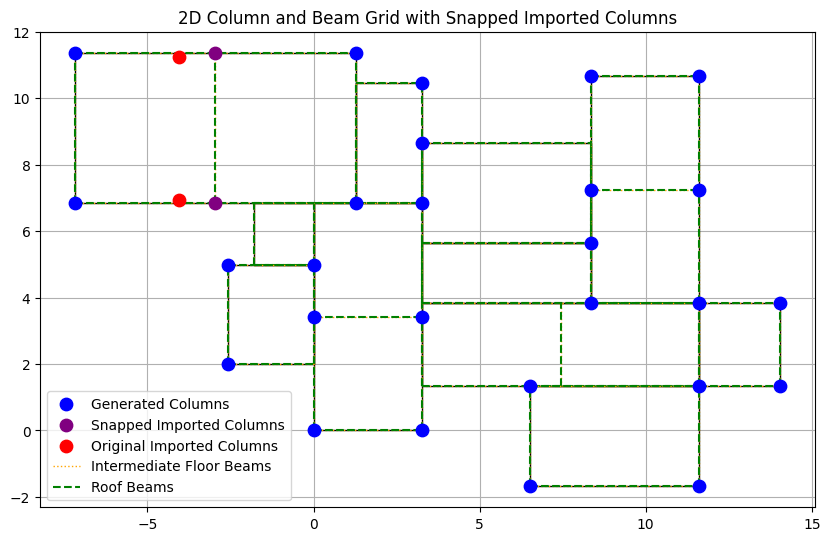

Widget(value='<iframe src="http://localhost:50772/index.html?ui=P_0x1e2a51d2fd0_1&reconnect=auto" class="pyvis…

In [2]:
 # DONT TOUCH correct

# 2. Imports
import rhino3dm 
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z 

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None

room_brep_map = {}   # Add this before your main for-loop over model.Objects

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z 
            room_brep_map[poly.wkt] = geom 


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2 # Corrected typo: bbox.Max.Y instead of bbox.Y
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                            label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                    label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    max_height = 0.0
    query_point = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']

        # Get the mesh from the Brep to find the actual Z values
        # We need to iterate through all faces and their vertices to find the highest Z
        # that is close to the given (x,y) point.
        all_meshes = []
        for face in brep.Faces:
            mesh = face.GetMesh(rhino3dm.MeshType.Render)
            if mesh:
                all_meshes.append(mesh)
        
        for mesh in all_meshes:
            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    # This fallback might be problematic for sloped roofs if it always returns the highest point
    # of the bbox, rather than the actual roof height at (x,y).
    # For a more robust solution, a raycast from (x,y) upwards to hit the roof mesh would be ideal,
    # but that's more complex with rhino3dm. For now, we rely on the vertex search and bbox as a last resort.
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            # Check if the point (x,y) is within the horizontal projection of the wall
            if Point(x, y).within(poly.buffer(search_radius)): # Use buffer to give some tolerance
                return wall['bbox'].Max.Z # This is the highest point of the bbox, not necessarily the point on the roof
        return max_z # Global max Z as ultimate fallback


    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Get the wall height at the column's location (which is the roof height)
    column_top_z = get_wall_height(x, y, wall_breps)
    
    # Column height goes from global min_z to the roof height at its location
    column_height = column_top_z - min_z_global
    column_center_z = min_z_global + column_height / 2

    # Ensure column height is positive
    if column_height > 0.01: # Small threshold to avoid tiny/negative cylinders
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                radius=0.1, height=column_height)
        plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt) # Corrected typo here!
    if not brep:
        continue   # Skip if this room has no brep

    room_bbox = brep.GetBoundingBox() 
    room_min_z = room_bbox.Min.Z 
    room_max_z = room_bbox.Max.Z 

    # Calculate floor height for intermediate floors based on the room's bounding box height
    # We now calculate the height of the bounding box of the room, not the global max_z
    room_total_height = room_max_z - room_min_z
    
    # Avoid division by zero if num_floors is 1
    floor_height_interval = room_total_height / num_floors if num_floors > 0 else 0


    for floor in range(1, num_floors + 1):
        # Local wall data for getting specific roof height at beam's x,y coordinates
        local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}]

        if floor == num_floors:
            # For the top floor, keep the sloped roof
            z1_intended = get_wall_height(x1, y1, local_wall_data)
            z2_intended = get_wall_height(x2, y2, local_wall_data)
        else:
            # For intermediate floors, calculate based on bounding box, but clip to roof
            z_floor_level = room_min_z + floor * floor_height_interval
            
            # Get the actual roof height at beam's x,y coordinates
            roof_height_at_p1 = get_wall_height(x1, y1, local_wall_data)
            roof_height_at_p2 = get_wall_height(x2, y2, local_wall_data)

            # The beam's z should be the minimum of the calculated floor level and the roof height
            z1_intended = min(z_floor_level, roof_height_at_p1)
            z2_intended = min(z_floor_level, roof_height_at_p2)

        # Only draw the beam if it's below or at the roof height at both ends
        if z1_intended <= get_wall_height(x1, y1, local_wall_data) and z2_intended <= get_wall_height(x2, y2, local_wall_data):
            start = np.array([x1, y1, z1_intended])
            end = np.array([x2, y2, z2_intended])

            direction = end - start
            length = np.linalg.norm(direction)
            if length < 1e-6:
                continue
            direction = direction / length
            center = (start + end) / 2

            beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

            color = 'green' if floor == num_floors else 'orange'
            plotter.add_mesh(beam, color=color)


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

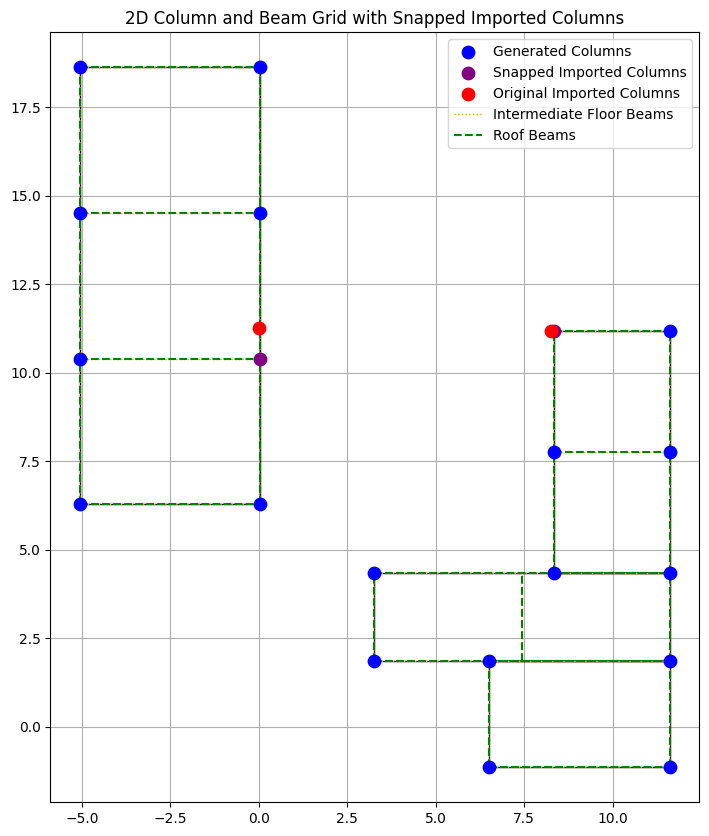

Widget(value='<iframe src="http://localhost:53674/index.html?ui=P_0x1849a1ba210_1&reconnect=auto" class="pyvis…

In [2]:
 # DONT TOUCH correct

# 2. Imports
import rhino3dm 
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z 

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None

room_brep_map = {}   # Add this before your main for-loop over model.Objects

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z 
            room_brep_map[poly.wkt] = geom 


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2 # Corrected typo: bbox.Max.Y instead of bbox.Y
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                            label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                    label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    max_height = 0.0
    query_point = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']

        # Get the mesh from the Brep to find the actual Z values
        # We need to iterate through all faces and their vertices to find the highest Z
        # that is close to the given (x,y) point.
        all_meshes = []
        for face in brep.Faces:
            mesh = face.GetMesh(rhino3dm.MeshType.Render)
            if mesh:
                all_meshes.append(mesh)
        
        for mesh in all_meshes:
            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    # This fallback might be problematic for sloped roofs if it always returns the highest point
    # of the bbox, rather than the actual roof height at (x,y).
    # For a more robust solution, a raycast from (x,y) upwards to hit the roof mesh would be ideal,
    # but that's more complex with rhino3dm. For now, we rely on the vertex search and bbox as a last resort.
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            # Check if the point (x,y) is within the horizontal projection of the wall
            if Point(x, y).within(poly.buffer(search_radius)): # Use buffer to give some tolerance
                return wall['bbox'].Max.Z # This is the highest point of the bbox, not necessarily the point on the roof
        return max_z # Global max Z as ultimate fallback


    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Get the wall height at the column's location (which is the roof height)
    column_top_z = get_wall_height(x, y, wall_breps)
    
    # Column height goes from global min_z to the roof height at its location
    column_height = column_top_z - min_z_global
    column_center_z = min_z_global + column_height / 2

    # Ensure column height is positive
    if column_height > 0.01: # Small threshold to avoid tiny/negative cylinders
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                radius=0.1, height=column_height)
        plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt) # Corrected typo here!
    if not brep:
        continue   # Skip if this room has no brep

    room_bbox = brep.GetBoundingBox() 
    room_min_z = room_bbox.Min.Z 
    room_max_z = room_bbox.Max.Z 

    # Calculate floor height for intermediate floors based on the room's bounding box height
    # We now calculate the height of the bounding box of the room, not the global max_z
    room_total_height = room_max_z - room_min_z
    
    # Avoid division by zero if num_floors is 1
    floor_height_interval = room_total_height / num_floors if num_floors > 0 else 0


    for floor in range(1, num_floors + 1):
        # Local wall data for getting specific roof height at beam's x,y coordinates
        local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}]

        if floor == num_floors:
            # For the top floor, keep the sloped roof
            z1_intended = get_wall_height(x1, y1, local_wall_data)
            z2_intended = get_wall_height(x2, y2, local_wall_data)
        else:
            # For intermediate floors, calculate based on bounding box, but clip to roof
            z_floor_level = room_min_z + floor * floor_height_interval
            
            # Get the actual roof height at beam's x,y coordinates
            roof_height_at_p1 = get_wall_height(x1, y1, local_wall_data)
            roof_height_at_p2 = get_wall_height(x2, y2, local_wall_data)

            # The beam's z should be the minimum of the calculated floor level and the roof height
            z1_intended = min(z_floor_level, roof_height_at_p1)
            z2_intended = min(z_floor_level, roof_height_at_p2)

        # Only draw the beam if it's below or at the roof height at both ends
        if z1_intended <= get_wall_height(x1, y1, local_wall_data) and z2_intended <= get_wall_height(x2, y2, local_wall_data):
            start = np.array([x1, y1, z1_intended])
            end = np.array([x2, y2, z2_intended])

            direction = end - start
            length = np.linalg.norm(direction)
            if length < 1e-6:
                continue
            direction = direction / length
            center = (start + end) / 2

            beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

            color = 'green' if floor == num_floors else 'orange'
            plotter.add_mesh(beam, color=color)


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

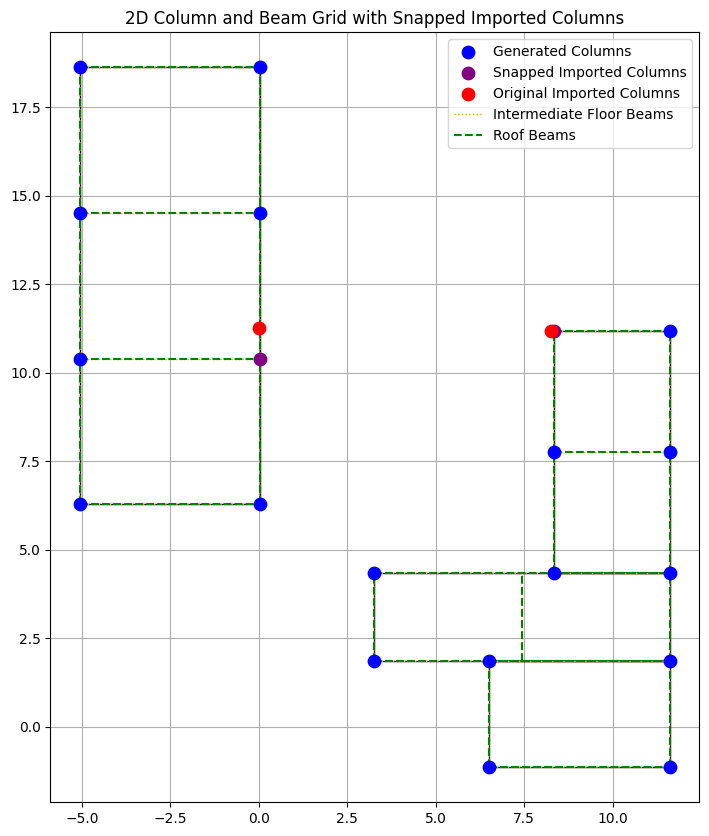

Widget(value='<iframe src="http://localhost:61263/index.html?ui=P_0x2b991ce1a90_11&reconnect=auto" class="pyvi…

In [15]:
# DONT TOUCH!!!

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z

wall_breps = []

from shapely.geometry import Polygon
from shapely.ops import unary_union

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)

    return None

room_brep_map = {}   # Add this before your main for-loop over model.Objects

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z
            room_brep_map[poly.wkt] = geom 


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                            label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                    label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    max_height = 0.0
    query_point = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']

        for face in brep.Faces:
            mesh = face.GetMesh(rhino3dm.MeshType.Render)
            if not mesh:
                continue

            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            dist = poly.exterior.distance(Point(x, y))
            if dist < search_radius:
                return wall['bbox'].Max.Z
        return max_z

    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Use the global min_z for the column base, and wall_height for the top
    wall_height = get_wall_height(x, y, wall_breps)
    column_height = wall_height - min_z_global
    column_center_z = min_z_global + column_height / 2
    cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                            radius=0.1, height=column_height)

    plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt)
    if not brep:
        continue   # Skip if this room has no brep

    # Get the bounding box for the current room's BREP
    room_bbox = brep.GetBoundingBox()
    room_min_z = room_bbox.Min.Z
    room_max_z = room_bbox.Max.Z

    # Calculate floor height for intermediate floors based on the room's bounding box height
    floor_height_interval = (room_max_z - room_min_z) / num_floors


    for floor in range(1, num_floors + 1):
        if floor == num_floors:
            # For the top floor, keep the sloped roof
            local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}]
            z1 = get_wall_height(x1, y1, local_wall_data)
            z2 = get_wall_height(x2, y2, local_wall_data)
        else:
            # For intermediate floors, use the bounding box min Z and divide the total height
            z1 = z2 = room_min_z + floor * floor_height_interval

        start = np.array([x1, y1, z1])
        end = np.array([x2, y2, z2])

        direction = end - start
        length = np.linalg.norm(direction)
        if length < 1e-6:
            continue
        direction = direction / length
        center = (start + end) / 2

        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        color = 'green' if floor == num_floors else 'orange'
        plotter.add_mesh(beam, color=color)


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

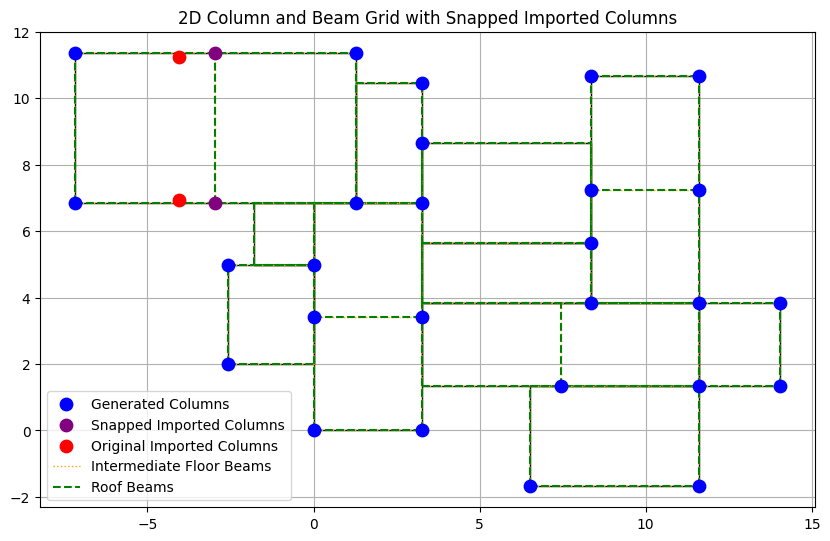

Widget(value='<iframe src="http://localhost:61263/index.html?ui=P_0x2ba0907c050_9&reconnect=auto" class="pyvis…

In [13]:
# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
# Using the path you specified in your prompt for this specific problem
# [2025-06-09] User saved preference: rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
# However, for this specific problem, the prompt specifies:
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever - Copy.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
if model is None:
    raise RuntimeError(f"Could not read Rhino model from {rhino_path}. It might be corrupted or an invalid file.")

layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = [] # Stores (shapely.Polygon, rhino3dm.Brep, bbox) for all building parts
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z

# wall_breps will now store (polygon, bbox, brep) for all building parts
wall_breps = []

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area) # Return the largest polygon from MultiPolygon
        else:
            return None # Handle other unexpected geometry types
    return None

# room_brep_map will map the WKT of the polygon to the original BREP and its bbox
room_brep_info_map = {}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly) # Only store the polygon here for now
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom}) # Store full info for height lookup
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z)
            room_brep_info_map[poly.wkt] = {'brep': geom, 'bbox': bbox} # Store brep and bbox

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting (by area, largest first)
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    # Use the specific room_poly for generating beams within its bounds
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    
    # Ensure divisions are at least 1 to avoid issues with very small rooms
    divisions_x = max(1, int(np.ceil(width / MaxS)))
    divisions_y = max(1, int(np.ceil(height / MaxS)))
    
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        # Check if the candidate column is inside the current room_poly
        if not Point(col).within(room_poly.buffer(0.01)): # Small buffer for floating point inaccuracies
            continue

        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                if col not in existing_columns:
                    existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap:
            if all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
                columns.append(col)
                existing_columns.append(col)

    for x in x_points:
        start_point = (x, miny)
        end_point = (x, maxy)
        # Ensure the beam segment is actually within the current room_poly
        if LineString([start_point, end_point]).intersects(room_poly):
             beams.append((start_point, end_point, room_poly))
    for y in y_points:
        start_point = (minx, y)
        end_point = (maxx, y)
        if LineString([start_point, end_point]).intersects(room_poly):
            beams.append((start_point, end_point, room_poly))

    # Add corner columns if they are not too close to existing ones
    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns (those not snapped)
remaining_imported_columns = [col for col in imported_columns if col not in corrected_columns]
if remaining_imported_columns:
    ix, iy = zip(*remaining_imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams: # The _ is a placeholder for the room_poly from `beams` list, not used here for plotting 2D.
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                                     label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                                 label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    """
    Finds the maximum Z-coordinate (height) of a wall mesh vertex within a given
    search radius of the (x,y) query point.
    Falls back to bounding box Max.Z if no mesh vertex is found nearby,
    and then to global max_z.
    """
    max_height = 0.0
    query_point_2d = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']
        all_meshes = []
        for face in brep.Faces:
            try: # Add try-except for mesh generation
                mesh = face.GetMesh(rhino3dm.MeshType.Render)
                if mesh:
                    all_meshes.append(mesh)
            except Exception as e:
                # print(f"Warning: Could not get mesh for face. Error: {e}")
                continue # Skip to the next face if meshing fails

        for mesh in all_meshes:
            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point_2d - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # If no mesh vertex was found, use the bounding box Max.Z if the point is within the 2D polygon
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            if Point(x, y).within(poly.buffer(search_radius)):
                return wall['bbox'].Max.Z
        # If no wall contains the point, return the global max Z
        return max_z

    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Get the wall height at the column's location (which is the roof height)
    # The get_wall_height function will try to find a relevant wall in wall_breps
    column_top_z = get_wall_height(x, y, wall_breps)

    # Column height goes from global min_z to the roof height at its location
    column_height = column_top_z - min_z_global
    column_center_z = min_z_global + column_height / 2

    # Ensure column height is positive and reasonable
    if column_height > 0.1: # Small threshold to avoid tiny/negative cylinders (e.g., 10cm minimum height)
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                 radius=0.1, height=column_height)
        plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04

# Calculate a typical floor height based on the overall building
# This helps ensure consistent floor spacing across different volumes
if num_floors > 0:
    typical_floor_height = (max_z - min_z_global) / num_floors
else:
    typical_floor_height = 0 # Handle case of 0 floors

for (x1, y1), (x2, y2), beam_defining_poly in beams:
    # Get the brep and bbox information for the specific polygon this beam is associated with
    room_info = room_brep_info_map.get(beam_defining_poly.wkt)
    if not room_info:
        continue # Should not happen if room_brep_info_map is populated correctly

    brep = room_info['brep']
    room_bbox = room_info['bbox']
    room_min_z = room_bbox.Min.Z # The specific room's minimum Z (its "ground" or "levitating" floor)
    room_max_z = room_bbox.Max.Z # The specific room's maximum Z (its roof)

    # Use a small buffer for intersection checks to account for floating point inaccuracies
    beam_line = LineString([(x1, y1), (x2, y2)])
    if not beam_line.intersects(beam_defining_poly.buffer(0.01)):
        continue # Skip if the beam segment falls outside its defined polygon

    # Iterate from 0 (base floor) up to num_floors (roof)
    for floor_idx in range(num_floors + 1):
        # NEW: Skip drawing a base beam if the room's minimum Z is approximately at the global ground level
        if floor_idx == 0 and abs(room_min_z - min_z_global) < 0.01: # Check if room is at global ground level (with tolerance)
            continue # Skip drawing a base beam for ground-level rooms
        
        if floor_idx == 0:
            # This is the base floor of the room (only for non-ground level rooms due to the check above)
            z_current_level = room_min_z
        else:
            # Intermediate or roof floor
            z_current_level = room_min_z + (floor_idx * typical_floor_height)

        # Get the actual roof heights at the beam's endpoints for clipping
        # Pass only the relevant wall data for this specific room
        roof_height_at_p1 = get_wall_height(x1, y1, [{'polygon': beam_defining_poly, 'brep': brep, 'bbox': room_bbox}])
        roof_height_at_p2 = get_wall_height(x2, y2, [{'polygon': beam_defining_poly, 'brep': brep, 'bbox': room_bbox}]) # Corrected this line

        # The beam's Z should be capped by the actual roof height of its associated room
        z1_intended = min(z_current_level, roof_height_at_p1)
        z2_intended = min(z_current_level, roof_height_at_p2)

        # Ensure the beam is within the vertical bounds of its associated room
        # Add a small tolerance to avoid floating point issues
        if z1_intended < room_min_z - 0.1 and z2_intended < room_min_z - 0.1:
            continue
        if z1_intended > room_max_z + 0.1 and z2_intended > room_max_z + 0.1:
            continue

        start = np.array([x1, y1, z1_intended])
        end = np.array([x2, y2, z2_intended])

        direction = end - start
        length = np.linalg.norm(direction)

        if length < 0.1: # Minimum beam length threshold (e.g., 10cm)
            continue
        
        direction = direction / length
        center = (start + end) / 2

        beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

        # Determine color based on floor_idx
        if floor_idx == num_floors:
            color = 'green' # Roof beams
        elif floor_idx == 0:
            color = 'gold' # Base beams (now only for non-ground level rooms)
        else:
            color = 'orange' # Intermediate floor beams
            
        plotter.add_mesh(beam, color=color)


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except Exception as e:
            # print(f"Error meshing face: {e}") # Suppress this as it can be noisy
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                    faces.append((4,) + idxs)
                elif len(f) == 3:
                    idxs = (f[0], f[1], f[2])
                    faces.append((3,) + idxs)
            faces_flat = [i for face in faces for i in face]
            if pts and faces_flat:
                pv_mesh = pv.PolyData(pts, faces_flat)
                plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

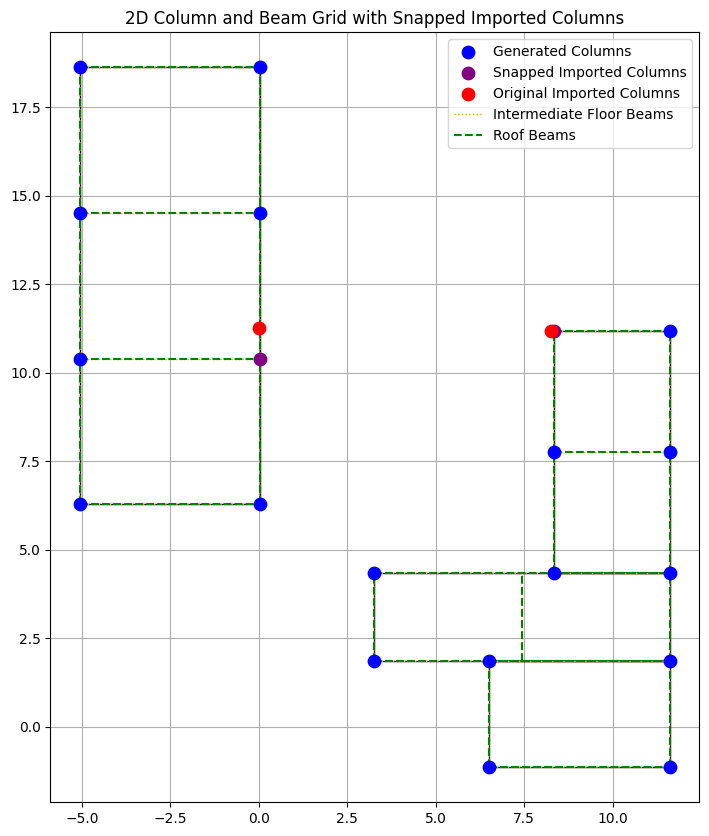


--- Analyzing Beams for Levitating Over Sloped Roof ---

--- Beam Segment Analysis ---
  2D Coords: (-5.05, 6.29) to (-5.05, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Intermediate (Floor 1)
  Beam Zs: Start=1.52, End=1.52
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Segment Analysis ---
  2D Coords: (-5.05, 6.29) to (-5.05, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Roof
  Beam Zs: Start=3.02, End=3.02
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Segment Analysis ---
  2D Coords: (0.04, 6.29) to (0.04, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Intermediate (Floor 1)
  Beam Zs: Start=1.52, End=1.52
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Se

Widget(value='<iframe src="http://localhost:61263/index.html?ui=P_0x2b9a20b2850_13&reconnect=auto" class="pyvi…

In [17]:
# DONT TOUCH!!!

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, LineString # LineString is used for the previous (now reverted) clipping logic, kept for other uses.
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
if model is None:
    raise RuntimeError(f"Could not read Rhino model from {rhino_path}. It might be corrupted or an invalid file.")

layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0
min_z_global = float('inf') # Initialize global min_z

wall_breps = []

def brep_to_floor_polygon(brep):
    all_polygons = []

    for face in brep.Faces:
        mesh = face.GetMesh(rhino3dm.MeshType.Render)
        if not mesh:
            continue

        for i in range(len(mesh.Faces)):
            f = mesh.Faces[i]
            idxs = list(f)

            # Handle triangle or quad
            if len(idxs) == 4:
                idxs = idxs[:4]
            elif len(idxs) == 3:
                idxs = idxs[:3]

            verts = [mesh.Vertices[j] for j in idxs]
            points_2d = [(v.X, v.Y) for v in verts]

            if len(points_2d) >= 3:
                try:
                    polygon = Polygon(points_2d)
                    if polygon.is_valid and polygon.area > 0:
                        all_polygons.append(polygon)
                except:
                    continue

    if all_polygons:
        union = unary_union(all_polygons)
        if union.geom_type == 'Polygon':
            return union
        elif union.geom_type == 'MultiPolygon':
            return max(union.geoms, key=lambda p: p.area)
        else:
            return None
    return None

room_brep_map = {}

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        poly = brep_to_floor_polygon(geom)
        if poly:
            bbox = geom.GetBoundingBox()
            building_volumes.append(poly)
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom})
            max_z = max(max_z, bbox.Max.Z)
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z
            room_brep_map[poly.wkt] = geom


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    # REVERTED: Removed the LineString.intersects() condition here to match original behavior
    for x in x_points:
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info
    for y in y_points:
        beams.append(((minx, y), (maxx, y), room_poly))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)


# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns: # Changed back to original logic to show all imported columns
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2), _ in beams:
    # Ensure beam is long enough for visualization - this was already in your code, keeping it.
    if np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2])) < 0.1:
        continue

    if num_floors > 1:
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                                     label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                                 label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

def get_wall_height(x, y, wall_data, search_radius=0.5):
    """
    Finds the maximum Z-coordinate (height) of a wall mesh vertex within a given
    search radius of the (x,y) query point.
    Falls back to bounding box Max.Z if no mesh vertex is found nearby,
    and then to global max_z.
    """
    max_height = 0.0
    query_point_2d = np.array([x, y])

    for wall in wall_data:
        brep = wall['brep']
        all_meshes = []
        for face in brep.Faces:
            try:
                m = face.GetMesh(rhino3dm.MeshType.Render)
                if m:
                    all_meshes.append(m)
            except Exception as e:
                continue

        for mesh in all_meshes:
            for i in range(len(mesh.Vertices)):
                v = mesh.Vertices[i]
                vx, vy, vz = v.X, v.Y, v.Z
                dist = np.linalg.norm(query_point_2d - np.array([vx, vy]))
                if dist < search_radius:
                    max_height = max(max_height, vz)

    # Fallback: if nothing found within radius, use bounding box max
    if max_height == 0.0:
        for wall in wall_data:
            poly = wall['polygon']
            # Check if point is within the polygon, then use its bbox max Z
            if Point(x, y).within(poly.buffer(search_radius)): # Use buffer for robustness
                return wall['bbox'].Max.Z
        return max_z # Return global max_z if no relevant wall found

    return max_height


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    # Use the global min_z for the column base, and wall_height for the top
    column_top_z = get_wall_height(x, y, wall_breps)
    column_height = column_top_z - min_z_global
    column_center_z = min_z_global + column_height / 2
    
    # Ensure column height is positive and reasonable
    if column_height > 0.1: # Small threshold to avoid tiny/negative cylinders (e.g., 10cm minimum height)
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                 radius=0.1, height=column_height)
        plotter.add_mesh(cylinder, color='blue')

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1

# Define a tolerance for detecting "levitating" beams
LEVITATING_TOLERANCE = 0.1 # 10 cm, tune as needed

print("\n--- Analyzing Beams for Levitating Over Sloped Roof ---")

for (x1, y1), (x2, y2), poly in beams:
    brep = room_brep_map.get(poly.wkt)
    if not brep:
        continue   # Skip if this room has no brep

    # Get the bounding box for the current room's BREP
    room_bbox = brep.GetBoundingBox()
    room_min_z = room_bbox.Min.Z
    room_max_z = room_bbox.Max.Z

    # Calculate floor height for intermediate floors based on the room's bounding box height
    floor_height_interval = (room_max_z - room_min_z) / num_floors


    for floor in range(1, num_floors + 1): # Iterate from 1 up to num_floors for structural floors
        z1_beam = None
        z2_beam = None
        floor_type = ""

        if floor == num_floors:
            # For the top floor, keep the sloped roof
            # REVERTED: Using local_wall_data as in original code
            local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}]
            z1_beam = get_wall_height(x1, y1, local_wall_data)
            z2_beam = get_wall_height(x2, y2, local_wall_data)
            floor_type = "Roof"
        else:
            # For intermediate floors, use the bounding box min Z and divide the total height
            # REMOVED: The `if floor == 0` check here, as the loop starts at 1, making it irrelevant.
            z1_beam = z2_beam = room_min_z + floor * floor_height_interval
            floor_type = f"Intermediate (Floor {floor})"

        # If z_beam values were calculated (i.e., not skipped by conditions like ground-level base beam)
        if z1_beam is not None and z2_beam is not None:
            # Get the actual architectural surface Z at these points from the *entire* building model
            # This is crucial for *comparison* to find levitating beams.
            actual_arch_z1 = get_wall_height(x1, y1, wall_breps) # Use global wall_breps for comparison
            actual_arch_z2 = get_wall_height(x2, y2, wall_breps) # Use global wall_breps for comparison

            # Determine if it's levitating
            # A beam is considered levitating if *both* its start and end points are significantly above the architectural surface
            is_levitating_at_p1 = (z1_beam > actual_arch_z1 + LEVITATING_TOLERANCE)
            is_levitating_at_p2 = (z2_beam > actual_arch_z2 + LEVITATING_TOLERANCE)
            
            is_overall_levitating = is_levitating_at_p1 and is_levitating_at_p2

            print(f"\n--- Beam Segment Analysis ---")
            print(f"  2D Coords: ({x1:.2f}, {y1:.2f}) to ({x2:.2f}, {y2:.2f})")
            print(f"  Associated Room WKT: {poly.wkt[:50]}...") # Print a truncated WKT for readability
            print(f"  Floor Type: {floor_type}")
            print(f"  Beam Zs: Start={z1_beam:.2f}, End={z2_beam:.2f}")
            print(f"  Actual Architectural Zs: Start={actual_arch_z1:.2f}, End={actual_arch_z2:.2f}")
            print(f"  Is Levitating over Architectural Surface? {'YES' if is_overall_levitating else 'NO'}")
            if is_overall_levitating:
                print(f"    (Beam Z - Arch Z Differences): Start={z1_beam - actual_arch_z1:.2f}, End={z2_beam - actual_arch_z2:.2f}")

            # Prepare beam for PyVista visualization (existing logic)
            start = np.array([x1, y1, z1_beam])
            end = np.array([x2, y2, z2_beam])

            direction = end - start
            length = np.linalg.norm(direction)
            if length < 1e-6: # Skip very short beams
                continue
            direction = direction / length
            center = (start + end) / 2

            beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length)

            # Determine color based on floor and levitating status
            if is_overall_levitating:
                plotter.add_mesh(beam, color='red', opacity=0.8, lighting=True, render_lines_as_tubes=True, line_width=10) # Make levitating beams very noticeable
            elif floor == num_floors:
                color = 'green' # Roof beams
            else: # Intermediate floor beams (and previously base beams, now handled by floor_idx in previous loop)
                color = 'orange'
            
            # Add to plotter only if not already added by levitating logic
            if not is_overall_levitating:
                 plotter.add_mesh(beam, color=color) # Only add if not marked red already


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except Exception as e:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                    faces.append((4,) + idxs)
                elif len(f) == 3:
                    idxs = (f[0], f[1], f[2])
                    faces.append((3,) + idxs)
                else:
                    continue # Skip faces with unexpected number of vertices
            faces_flat = [i for face in faces for i in face]
            if pts and faces_flat:
                pv_mesh = pv.PolyData(pts, faces_flat)
                plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

# Set up the camera and show
plotter.show_grid()
plotter.show()

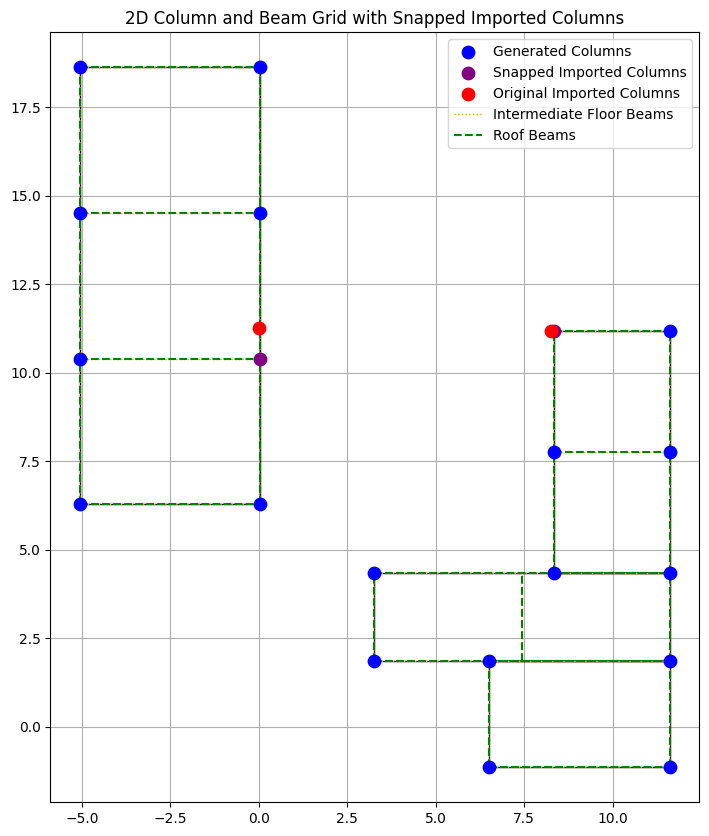


--- Analyzing Beams for Levitating Over Sloped Roof ---

--- Beam Segment Analysis ---
  2D Coords: (-5.05, 6.29) to (-5.05, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Intermediate (Floor 1)
  Beam Zs: Start=1.52, End=1.52
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Segment Analysis ---
  2D Coords: (-5.05, 6.29) to (-5.05, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Roof
  Beam Zs: Start=3.02, End=3.02
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Segment Analysis ---
  2D Coords: (0.04, 6.29) to (0.04, 18.63)
  Associated Room WKT: POLYGON ((-5.052224159240723 18.633899688720703, 0...
  Floor Type: Intermediate (Floor 1)
  Beam Zs: Start=1.52, End=1.52
  Actual Architectural Zs: Start=3.02, End=3.02
  Is Levitating over Architectural Surface? NO

--- Beam Se

Widget(value='<iframe src="http://localhost:61263/index.html?ui=P_0x2ba3fd94f50_14&reconnect=auto" class="pyvi…

In [18]:
# DONT TOUCH!!!

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3darchitecturalmonastery.3dm" #
if not os.path.exists(rhino_path): #
    raise FileNotFoundError(f"File not found: {rhino_path}") #

# Load model
model = rhino3dm.File3dm.Read(rhino_path) #
if model is None: #
    raise RuntimeError(f"Could not read Rhino model from {rhino_path}. It might be corrupted or an invalid file.") #

layers = {layer.Name.lower(): layer.Index for layer in model.Layers} #
if 'building' not in layers or ('column' not in layers and 'columns' not in layers): #
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.") #

column_layer = 'columns' if 'columns' in layers else 'column' #

# Extract building volume & height
building_volumes = [] #
imported_columns = [] #
max_z = 0.0 #
min_z_global = float('inf') # Initialize global min_z #

wall_breps = [] #

def brep_to_floor_polygon(brep):
    all_polygons = [] #

    for face in brep.Faces: #
        mesh = face.GetMesh(rhino3dm.MeshType.Render) #
        if not mesh: #
            continue #

        for i in range(len(mesh.Faces)): #
            f = mesh.Faces[i] #
            idxs = list(f) #

            # Handle triangle or quad
            if len(idxs) == 4: #
                idxs = idxs[:4] #
            elif len(idxs) == 3: #
                idxs = idxs[:3] #

            verts = [mesh.Vertices[j] for j in idxs] #
            points_2d = [(v.X, v.Y) for v in verts] #

            if len(points_2d) >= 3: #
                try: #
                    polygon = Polygon(points_2d) #
                    if polygon.is_valid and polygon.area > 0: #
                        all_polygons.append(polygon) #
                except: #
                    continue #

    if all_polygons: #
        union = unary_union(all_polygons) #
        if union.geom_type == 'Polygon': #
            return union #
        elif union.geom_type == 'MultiPolygon': #
            return max(union.geoms, key=lambda p: p.area) #
        else: #
            return None #
    return None #

room_brep_map = {} #

for obj in model.Objects: #
    layer_idx = obj.Attributes.LayerIndex #
    geom = obj.Geometry #

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep: #
        poly = brep_to_floor_polygon(geom) #
        if poly: #
            bbox = geom.GetBoundingBox() #
            building_volumes.append(poly) #
            wall_breps.append({'polygon': poly, 'bbox': bbox, 'brep': geom}) #
            max_z = max(max_z, bbox.Max.Z) #
            min_z_global = min(min_z_global, bbox.Min.Z) # Update global min_z #
            room_brep_map[poly.wkt] = geom #


    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep: #
        bbox = geom.GetBoundingBox() #
        center_x = (bbox.Min.X + bbox.Max.X) / 2 #
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2 #
        imported_columns.append((center_x, center_y)) #

if not building_volumes: #
    raise RuntimeError("No valid building geometry found on the 'building' layer.") #

# Ask for number of floors
while True: #
    try: #
        num_floors = int(input("How many floors does the building have? (e.g., 2): ")) #
        if num_floors < 1: #
            raise ValueError #
        break #
    except ValueError: #
        print("Please enter a valid positive integer for the number of floors.") #

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1]) #

# Structural logic
MaxS = 6.0 #
MinS = 3.0 #

columns = [] #
corrected_columns = [] #
available_imported = imported_columns.copy() #
existing_columns = imported_columns.copy() #
beams = [] #

for room_poly, _ in detected_rooms: #
    minx, miny, maxx, maxy = room_poly.bounds #
    width, height = maxx - minx, maxy - miny #
    divisions_x = int(np.ceil(width / MaxS)) #
    divisions_y = int(np.ceil(height / MaxS)) #
    x_points = np.linspace(minx, maxx, divisions_x + 1) #
    y_points = np.linspace(miny, maxy, divisions_y + 1) #
    room_candidates = [(x, y) for x in x_points for y in y_points] #

    for col in room_candidates: #
        snap = False #
        for imp_col in available_imported: #
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS: #
                corrected_columns.append(col) #
                existing_columns.append(col) #
                available_imported.remove(imp_col) #
                snap = True #
                break #
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns): #
            columns.append(col) #
            existing_columns.append(col) #

    # REVERTED: Removed the LineString.intersects() condition here to match original behavior
    for x in x_points: #
        beams.append(((x, miny), (x, maxy), room_poly))   # Add room info #
    for y in y_points: #
        beams.append(((minx, y), (maxx, y), room_poly)) #

    for corner in list(room_poly.exterior.coords): #
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns): #
            columns.append(corner) #
            existing_columns.append(corner) #


# Combine all base columns
all_base_columns = columns + corrected_columns #

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10)) #

# Room outlines
for poly, _ in detected_rooms: #
    px, py = poly.exterior.xy #
    ax.plot(px, py, 'k-', linewidth=1) #

# Generated columns
if columns: #
    gx, gy = zip(*columns) #
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5) #

# Snapped imported columns
if corrected_columns: #
    cx, cy = zip(*corrected_columns) #
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7) #

# Original imported columns
if imported_columns: # Changed back to original logic to show all imported columns #
    ix, iy = zip(*imported_columns) #
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10) #

intermediate_label_added = False #
roof_label_added = False #

for (x1, y1), (x2, y2), _ in beams: #
    # Ensure beam is long enough for visualization - this was already in your code, keeping it.
    if np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2])) < 0.1: #
        continue #

    if num_floors > 1: #
        for floor in range(1, num_floors):   # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                                     label='Intermediate Floor Beams' if not intermediate_label_added else "") #
            intermediate_label_added = True #

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
                                 label='Roof Beams' if not roof_label_added else "") #
    roof_label_added = True #

ax.set_aspect('equal', 'box') #
ax.legend() #
plt.title("2D Column and Beam Grid with Snapped Imported Columns") #
ax.grid(True) #
plt.show() #

def get_wall_height(x, y, wall_data, search_radius=0.5):
    """
    Finds the maximum Z-coordinate (height) of a wall mesh vertex within a given
    search radius of the (x,y) query point.
    Falls back to bounding box Max.Z if no mesh vertex is found nearby,
    and then to global max_z.
    """
    max_height = 0.0 #
    query_point_2d = np.array([x, y]) #

    for wall in wall_data: #
        brep = wall['brep'] #
        all_meshes = [] #
        for face in brep.Faces: #
            try: #
                m = face.GetMesh(rhino3dm.MeshType.Render) #
                if m: #
                    all_meshes.append(m) #
            except Exception as e: #
                continue #

        for mesh in all_meshes: #
            for i in range(len(mesh.Vertices)): #
                v = mesh.Vertices[i] #
                vx, vy, vz = v.X, v.Y, v.Z #
                dist = np.linalg.norm(query_point_2d - np.array([vx, vy])) #
                if dist < search_radius: #
                    max_height = max(max_height, vz) #

    # Fallback: if nothing found within radius, use bounding box max
    if max_height == 0.0: #
        for wall in wall_data: #
            poly = wall['polygon'] #
            # Check if point is within the polygon, then use its bbox max Z
            if Point(x, y).within(poly.buffer(search_radius)): # Use buffer for robustness #
                return wall['bbox'].Max.Z #
        return max_z # Return global max_z if no relevant wall found #

    return max_height #


# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System") #

# Columns as vertical cylinders
for x, y in all_base_columns: #
    # Use the global min_z for the column base, and wall_height for the top
    column_top_z = get_wall_height(x, y, wall_breps) #
    column_height = column_top_z - min_z_global #
    column_center_z = min_z_global + column_height / 2 #
    
    # Ensure column height is positive and reasonable
    if column_height > 0.1: # Small threshold to avoid tiny/negative cylinders (e.g., 10cm minimum height) #
        cylinder = pv.Cylinder(center=(x, y, column_center_z), direction=(0, 0, 1),
                                 radius=0.1, height=column_height) #
        plotter.add_mesh(cylinder, color='blue') #

# Beams as thinner cylinders
beam_radius = 0.04   # thinner than column radius 0.1 #

# Define a tolerance for detecting "levitating" beams
LEVITATING_TOLERANCE = 0.1 # 10 cm, tune as needed #

print("\n--- Analyzing Beams for Levitating Over Sloped Roof ---") #

for (x1, y1), (x2, y2), poly in beams: #
    brep = room_brep_map.get(poly.wkt) #
    if not brep: #
        continue   # Skip if this room has no brep #

    # Get the bounding box for the current room's BREP
    room_bbox = brep.GetBoundingBox() #
    room_min_z = room_bbox.Min.Z #
    room_max_z = room_bbox.Max.Z #

    # Calculate floor height for intermediate floors based on the room's bounding box height
    floor_height_interval = (room_max_z - room_min_z) / num_floors #


    for floor in range(1, num_floors + 1): # Iterate from 1 up to num_floors for structural floors #
        z1_beam = None #
        z2_beam = None #
        floor_type = "" #

        if floor == num_floors: #
            # For the top floor, keep the sloped roof
            # REVERTED: Using local_wall_data as in original code
            local_wall_data = [{'polygon': poly, 'brep': brep, 'bbox': room_bbox}] #
            z1_beam = get_wall_height(x1, y1, local_wall_data) #
            z2_beam = get_wall_height(x2, y2, local_wall_data) #
            floor_type = "Roof" #
        else: #
            # For intermediate floors, use the bounding box min Z and divide the total height
            # REMOVED: The `if floor == 0` check here, as the loop starts at 1, making it irrelevant.
            z1_beam = z2_beam = room_min_z + floor * floor_height_interval #
            floor_type = f"Intermediate (Floor {floor})" #

        # If z_beam values were calculated (i.e., not skipped by conditions like ground-level base beam)
        if z1_beam is not None and z2_beam is not None: #
            # Get the actual architectural surface Z at these points from the *entire* building model
            # This is crucial for *comparison* to find levitating beams.
            actual_arch_z1 = get_wall_height(x1, y1, wall_breps) # Use global wall_breps for comparison #
            actual_arch_z2 = get_wall_height(x2, y2, wall_breps) # Use global wall_breps for comparison #

            # Determine if it's levitating
            # A beam is considered levitating if *both* its start and end points are significantly above the architectural surface
            is_levitating_at_p1 = (z1_beam > actual_arch_z1 + LEVITATING_TOLERANCE) #
            is_levitating_at_p2 = (z2_beam > actual_arch_z2 + LEVITATING_TOLERANCE) #
            
            is_overall_levitating = is_levitating_at_p1 and is_levitating_at_p2 #

            print(f"\n--- Beam Segment Analysis ---") #
            print(f"  2D Coords: ({x1:.2f}, {y1:.2f}) to ({x2:.2f}, {y2:.2f})") #
            print(f"  Associated Room WKT: {poly.wkt[:50]}...") # Print a truncated WKT for readability #
            print(f"  Floor Type: {floor_type}") #
            print(f"  Beam Zs: Start={z1_beam:.2f}, End={z2_beam:.2f}") #
            print(f"  Actual Architectural Zs: Start={actual_arch_z1:.2f}, End={actual_arch_z2:.2f}") #
            print(f"  Is Levitating over Architectural Surface? {'YES' if is_overall_levitating else 'NO'}") #
            if is_overall_levitating: #
                print(f"    (Beam Z - Arch Z Differences): Start={z1_beam - actual_arch_z1:.2f}, End={z2_beam - actual_arch_z2:.2f}") #

            # Prepare beam for PyVista visualization (existing logic)
            start = np.array([x1, y1, z1_beam]) #
            end = np.array([x2, y2, z2_beam]) #

            direction = end - start #
            length = np.linalg.norm(direction) #
            if length < 1e-6: # Skip very short beams #
                continue #
            direction = direction / length #
            center = (start + end) / 2 #

            beam = pv.Cylinder(center=center, direction=direction, radius=beam_radius, height=length) #

            # Determine color based on floor and levitating status
            if is_overall_levitating: #
                plotter.add_mesh(beam, color='red', opacity=0.8, lighting=True, render_lines_as_tubes=True, line_width=10) # Make levitating beams very noticeable #
            elif floor == num_floors: #
                color = 'green' # Roof beams #
            else: # Intermediate floor beams (and previously base beams, now handled by floor_idx in previous loop)
                color = 'orange' #
            
            # Add to plotter only if not already added by levitating logic
            if not is_overall_levitating: #
                 plotter.add_mesh(beam, color=color) # Only add if not marked red already #


# Actual Brep-based walls visualization
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any): #
    meshes = [] #
    for face in brep.Faces: #
        try: #
            m = face.GetMesh(mesh_type) #
            if m: meshes.append(m) #
        except Exception as e: #
            continue #
    return meshes #

for obj in model.Objects: #
    geom = obj.Geometry #
    layer_idx = obj.Attributes.LayerIndex #
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep): #
        meshes = mesh_brep(geom) #
        for mesh in meshes: #
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices] #
            faces = [] #
            for f in mesh.Faces: #
                if len(f) == 4: #
                    idxs = (f[0], f[1], f[2], f[3]) #
                    faces.append((4,) + idxs) #
                elif len(f) == 3: #
                    idxs = (f[0], f[1], f[2]) #
                    faces.append((3,) + idxs) #
                else: #
                    continue # Skip faces with unexpected number of vertices #
            faces_flat = [i for face in faces for i in face] #
            if pts and faces_flat: #
                pv_mesh = pv.PolyData(pts, faces_flat) #
                plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3) #

# Set up the camera and show
plotter.show_grid() #
plotter.show() #